In [143]:
import sys
import warnings
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import copy
import math
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_log_error
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from lightgbm import LGBMRegressor
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from smogn import smoter
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.5f}'.format

randomState = 100

In [4]:
print("Python version :", sys.version)
print("Numpy version :", np.__version__)
print("Pandas version :", pd.__version__)
print("Scipy version :", scipy.__version__)
print("Geopandas version :", gpd.__version__)

Python version : 3.11.3 | packaged by Anaconda, Inc. | (main, May 15 2023, 15:41:31) [MSC v.1916 64 bit (AMD64)]
Numpy version : 1.26.2
Pandas version : 2.1.3
Scipy version : 1.11.3
Geopandas version : 0.14.1


## 데이터 확인 및 전처리

### 전처리

In [76]:
# 학습 데이터 불러오기

df_train = pd.read_csv("./data/train.csv")

df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


In [3]:
# 컬럼별 데이터 라벨 확인

df_train.nunique()

ID             39609
사고일시           18057
요일                 7
기상상태               6
시군구              199
도로형태              11
노면상태               6
사고유형               3
사고유형 - 세부분류       14
법규위반              11
가해운전자 차종          12
가해운전자 성별           3
가해운전자 연령          89
가해운전자 상해정도         6
피해운전자 차종          13
피해운전자 성별           3
피해운전자 연령          97
피해운전자 상해정도         6
사망자수               3
중상자수               7
경상자수              18
부상자수               9
ECLO              46
dtype: int64

In [77]:
# 테스트 데이터 데이터 확인

df_test = pd.read_csv("./data/test.csv")

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    10963 non-null  object
dtypes: object(8)
memory usage: 685.3+ KB


In [5]:
# 테스트 데이터 라벨 확인

df_test.nunique()

ID      10963
사고일시     5548
요일          7
기상상태        5
시군구       192
도로형태       11
노면상태        6
사고유형        3
dtype: int64

In [6]:
# train-test 중 겹치는 컬럼의 데이터 라벨 확인

col_test = df_test.columns[1:]

for c in col_test : 
    print(c+"의 train unique")
    print(sorted(df_train[c].unique().tolist()))
    print("-----------------------")
    print(c+"의 test unique")
    print(sorted(df_test[c].unique().tolist()))
    print("********************")


# 시군구의 경우 test에 존재하는 값이 train에 전부 존재하는지 확인

사고일시의 train unique
['2019-01-01 00', '2019-01-01 01', '2019-01-01 02', '2019-01-01 04', '2019-01-01 05', '2019-01-01 06', '2019-01-01 10', '2019-01-01 11', '2019-01-01 14', '2019-01-01 18', '2019-01-01 19', '2019-01-01 20', '2019-01-01 22', '2019-01-02 01', '2019-01-02 02', '2019-01-02 07', '2019-01-02 08', '2019-01-02 10', '2019-01-02 11', '2019-01-02 13', '2019-01-02 14', '2019-01-02 15', '2019-01-02 16', '2019-01-02 17', '2019-01-02 18', '2019-01-02 19', '2019-01-02 20', '2019-01-02 22', '2019-01-02 23', '2019-01-03 00', '2019-01-03 02', '2019-01-03 03', '2019-01-03 05', '2019-01-03 07', '2019-01-03 08', '2019-01-03 10', '2019-01-03 11', '2019-01-03 12', '2019-01-03 13', '2019-01-03 14', '2019-01-03 15', '2019-01-03 17', '2019-01-03 18', '2019-01-03 19', '2019-01-03 20', '2019-01-03 21', '2019-01-03 22', '2019-01-03 23', '2019-01-04 00', '2019-01-04 01', '2019-01-04 04', '2019-01-04 05', '2019-01-04 06', '2019-01-04 07', '2019-01-04 08', '2019-01-04 10', '2019-01-04 11', '2019-01-04

In [7]:
uni_city = df_test["시군구"].unique().tolist()

len_city_test = len(uni_city)

len_city_train = len(df_train[df_train["시군구"].isin(uni_city)]["시군구"].unique())

if len_city_test == len_city_train : 
    print("test data의 시군구 값은 train data에 전부 속합니다.")

test data의 시군구 값은 train data에 전부 속합니다.


In [4]:
# train의 데이터의 일부와 test 데이터를 합쳐 모델 학습용 데이터로 만듦

# len_train = df_train.shape[0]
# len_test = df_test.shape[0]

# df_model = pd.concat((df_train[df_test.columns], df_test), axis=0)

# print(len_train+len_test)
# df_model.info()

In [78]:
# 불필요한 컬럼 정리

df_train.drop(labels=["ID"], axis=1, inplace=True)
df_test.drop(labels=["ID"], axis=1, inplace=True)

In [79]:
# 사고 일시 object -> datetime

df_train["사고일시"] = pd.to_datetime(df_train["사고일시"], format="%Y-%m-%d %H")
df_test["사고일시"] = pd.to_datetime(df_test["사고일시"], format="%Y-%m-%d %H")

print(df_train["사고일시"].dtypes)
print(df_test["사고일시"].dtypes)

datetime64[ns]
datetime64[ns]


In [11]:
# 컬럼별 결측치 갯수 확인

df_train.isnull().sum()

사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해운전자 연령       991
피해운전자 상해정도     991
사망자수             0
중상자수             0
경상자수             0
부상자수             0
ECLO             0
dtype: int64

결측치의 대부분이 피해 운전자이므로, 결측치가 존재하는 데이터의 사고 유형 등을 확인

In [7]:
df_train_null = df_train[df_train["피해운전자 차종"].isnull()]

print("null인 데이터의 사고 종류 :",df_train_null["사고유형"].unique())
print("null인 데이터의 상해 정도 종류 :",df_train_null["가해운전자 상해정도"].unique())

# 차량 단독으로 일어난 사고이므로 피해자가 없음, 차량 단독이지만 상해 종류는 다양

null인 데이터의 사고 종류 : ['차량단독']
null인 데이터의 상해 정도 종류 : ['중상' '경상' '상해없음' '부상신고' '사망' '기타불명']


In [13]:
# '차량 단독'이 전체 데이터 중 어느 정도 비율을 차지하는지 확인

df_train["사고유형"].value_counts()

사고유형
차대차     31785
차대사람     6833
차량단독      991
Name: count, dtype: int64

차량 단독의 전체 개수가 null 값인 사고 유형의 갯수와 일치하므로, 차량 단독 데이터를 제거할 수 없고 결측치 처리 필요

In [80]:
# 피해 운전자 관련 데이터의 label 확인

pihae = ['피해운전자 차종','피해운전자 성별','피해운전자 연령','피해운전자 상해정도']

for i in range(4) : 
    print(df_train[pihae[i]].unique())
    print("--------------------------")


# null 값을 '기타불명', '미분류' 등으로 대체

['보행자' '승용' '자전거' '승합' nan '이륜' '화물' '개인형이동수단(PM)' '사륜오토바이(ATV)' '특수'
 '원동기' '기타불명' '건설기계' '농기계']
--------------------------
['여' '남' nan '기타불명']
--------------------------
['70세' '61세' '38세' '36세' '52세' '35세' '76세' '53세' '62세' '42세' '60세' '69세'
 '31세' '23세' nan '57세' '17세' '54세' '55세' '64세' '41세' '44세' '58세' '45세'
 '30세' '59세' '34세' '68세' '32세' '21세' '56세' '18세' '37세' '39세' '27세' '65세'
 '43세' '12세' '75세' '4세' '71세' '40세' '48세' '14세' '19세' '66세' '63세' '50세'
 '20세' '67세' '26세' '22세' '47세' '16세' '28세' '46세' '51세' '29세' '33세' '24세'
 '79세' '80세' '74세' '78세' '72세' '49세' '73세' '5세' '13세' '77세' '9세' '86세'
 '15세' '84세' '25세' '82세' '10세' '8세' '85세' '7세' '11세' '88세' '미분류' '87세'
 '83세' '90세 이상' '3세' '81세' '6세' '89세' '2세' '1세' '91세' '90세' '93세' '94세'
 '92세' '98세 이상']
--------------------------
['중상' '경상' '상해없음' nan '부상신고' '사망' '기타불명']
--------------------------


In [81]:
# 결측치 채움

fill = ["기타불명", "기타불명", "미분류", "기타불명"]

for i in range(4) : 
    df_train[pihae[i]].fillna(fill[i], inplace=True)

df_train.isnull().sum()

사고일시           0
요일             0
기상상태           0
시군구            0
도로형태           0
노면상태           0
사고유형           0
사고유형 - 세부분류    0
법규위반           0
가해운전자 차종       0
가해운전자 성별       0
가해운전자 연령       0
가해운전자 상해정도     0
피해운전자 차종       0
피해운전자 성별       0
피해운전자 연령       0
피해운전자 상해정도     0
사망자수           0
중상자수           0
경상자수           0
부상자수           0
ECLO           0
dtype: int64

In [82]:
# 가해 연령 / 피해 연령 범주화

df_train["가해연령_수정"] = df_train["가해운전자 연령"].str.extract(r"([0-9]+)세")
df_train["피해연령_수정"] = df_train["피해운전자 연령"].str.extract(r"([0-9]+)세")

df_train[["가해연령_수정","피해연령_수정"]] = df_train[["가해연령_수정","피해연령_수정"]].fillna('9999')  # 미분류의 경우 숫자 분리가 안 돼 NaN을 반환하므로, 임의의 숫자를 채움

df_train[["가해연령_수정","피해연령_수정"]] = df_train[["가해연령_수정","피해연령_수정"]].astype(int)

df_train["가해연령대"] = pd.cut(x=df_train["가해연령_수정"], bins=[0,10,20,30,40,50,60,70,80,90,100,150,10000], 
                           labels=["영유아", "10대", "20대", "30대", "40대", "50대", "60대", "70대", "80대", "90대", "100세 이상", "미분류"],   # 연령대를 범주화
                           include_lowest=True)

df_train["피해연령대"] = pd.cut(x=df_train["피해연령_수정"], bins=[0,10,20,30,40,50,60,70,80,90,100,150,10000], 
                           labels=["영유아", "10대", "20대", "30대", "40대", "50대", "60대", "70대", "80대", "90대", "100세 이상", "미분류"],
                           include_lowest=True)

df_train[df_train["가해연령_수정"]==9999]

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,가해연령_수정,피해연령_수정,가해연령대,피해연령대
11,2019-01-01 14:00:00,화요일,맑음,대구광역시 동구 신기동,교차로 - 교차로안,건조,차대차,기타,안전운전불이행,기타불명,...,경상,0,0,1,0,3,9999,69,미분류,60대
38,2019-01-02 15:00:00,수요일,맑음,대구광역시 서구 이현동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,기타불명,...,부상신고,0,0,0,1,1,9999,32,미분류,30대
83,2019-01-03 20:00:00,목요일,맑음,대구광역시 북구 태전동,단일로 - 기타,건조,차대차,측면충돌,안전운전불이행,기타불명,...,중상,0,1,0,0,5,9999,66,미분류,60대
145,2019-01-05 17:00:00,토요일,맑음,대구광역시 북구 산격동,단일로 - 기타,건조,차대사람,기타,안전운전불이행,기타불명,...,경상,0,0,1,0,3,9999,36,미분류,30대
186,2019-01-07 02:00:00,월요일,맑음,대구광역시 달서구 진천동,단일로 - 기타,건조,차대차,기타,안전운전불이행,기타불명,...,부상신고,0,0,0,1,1,9999,56,미분류,50대
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39486,2021-12-28 13:00:00,화요일,맑음,대구광역시 달서구 진천동,단일로 - 기타,건조,차대사람,기타,안전운전불이행,기타불명,...,경상,0,0,1,0,3,9999,64,미분류,60대
39518,2021-12-29 16:00:00,수요일,맑음,대구광역시 수성구 범어동,단일로 - 기타,건조,차대사람,기타,안전운전불이행,기타불명,...,경상,0,0,1,0,3,9999,13,미분류,10대
39540,2021-12-30 11:00:00,목요일,맑음,대구광역시 수성구 범어동,단일로 - 기타,건조,차대차,기타,안전운전불이행,기타불명,...,상해없음,0,0,1,0,3,9999,35,미분류,30대
39578,2021-12-31 12:00:00,금요일,맑음,대구광역시 달성군 구지면,단일로 - 기타,건조,차대차,기타,안전거리미확보,기타불명,...,경상,0,0,1,0,3,9999,30,미분류,20대


### 외부 데이터 불러오기

In [83]:
# cctv 데이터

cctv = pd.read_csv("./data/external_open/대구 CCTV 정보.csv", encoding='cp949')

cctv.info()
cctv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   무인교통단속카메라관리번호  1065 non-null   object 
 1   시도명            1065 non-null   object 
 2   시군구명           1065 non-null   object 
 3   도로종류           1065 non-null   object 
 4   도로노선번호         288 non-null    object 
 5   도로노선명          1065 non-null   object 
 6   도로노선방향         1065 non-null   int64  
 7   소재지도로명주소       905 non-null    object 
 8   소재지지번주소        1065 non-null   object 
 9   위도             1065 non-null   float64
 10  경도             1065 non-null   float64
 11  설치장소           1065 non-null   object 
 12  단속구분           1065 non-null   int64  
 13  제한속도           1065 non-null   int64  
 14  단속구간위치구분       53 non-null     float64
 15  과속단속구간길이       26 non-null     float64
 16  보호구역구분         893 non-null    float64
 17  설치연도           1065 non-null   int64  
dtypes: float

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.83886,128.57542,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.00000,2010
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.84465,128.60462,효성백년가약,4,0,NaN,NaN,99.00000,2013
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,대구광역시 남구 봉덕동 866-46,35.84418,128.60481,강변코오롱하늘채,4,0,NaN,NaN,99.00000,2013
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,대구광역시 남구 대명동 2680-17,35.83480,128.58528,보성청록타운,4,0,NaN,NaN,99.00000,2014
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,대구광역시 남구 봉덕동 1616,35.83273,128.58832,환경차고지,4,0,NaN,NaN,99.00000,2014


In [18]:
cctv[["단속구분", "제한속도"]].value_counts().sort_index(ascending=False).to_frame()

count
단속구분 제한속도       
99   100      16
     80       25
     60        2
     50        4
     40        2
     30        2
4    0       232
2    80        3
     70       13
     60      126
     50      218
     40       67
     30      148
1    110       1
     100       3
     80        4
     70        9
     60       59
     50       52
     40       11
     30       68

보통 제한 속도를 보면서 운전을 하는 것이 아니라 cctv가 있을 때 속도를 줄이므로,  
단속 구분과 제한 속도는 의미가 없고 행정 구역별 갯수가 유의미할 것으로 판단

---

In [12]:
cctv.head()

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.83886,128.57542,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.00000,2010
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.84465,128.60462,효성백년가약,4,0,NaN,NaN,99.00000,2013
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,대구광역시 남구 봉덕동 866-46,35.84418,128.60481,강변코오롱하늘채,4,0,NaN,NaN,99.00000,2013
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,대구광역시 남구 대명동 2680-17,35.83480,128.58528,보성청록타운,4,0,NaN,NaN,99.00000,2014
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,대구광역시 남구 봉덕동 1616,35.83273,128.58832,환경차고지,4,0,NaN,NaN,99.00000,2014


In [84]:
cctv2019 = cctv[cctv["설치연도"]<=2018]
cctv2020 = cctv[cctv["설치연도"]<=2019]
cctv2021 = cctv[cctv["설치연도"]<=2020]

print(cctv2019.shape)
print(cctv2020.shape)
print(cctv2020.shape)

(506, 18)
(581, 18)
(581, 18)


In [14]:
cctv2019["설치장소"].value_counts()

설치장소
대구포항고속도로1.1K대구방향출구)          2
안지랑네거리1 버스정류장                1
유가사입구사거리(휴양림입구R→수목원)         1
비산육교앞(평리교→비산지하차도)            1
율하휴먼시아12단지정문앞(안심교→율하체육공원)    1
                            ..
국민은행 성서지점 부근                 1
대구은행 죽전점 부근                  1
성서네거리 부근                     1
성서우체국 부근                     1
삼일병원네거리(송현역→성당못역)            1
Name: count, Length: 505, dtype: int64

In [78]:
cctv2019[cctv2019["설치장소"]=='대구포항고속도로1.1K대구방향출구)']

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
381,F7245,대구광역시,동구,고속국도,20,대구포항고속도로,1,NaN,대구광역시 동구 평광동 산 147-1,35.93722,128.68776,대구포항고속도로1.1K대구방향출구),99,100,2.00000,9.48100,99.00000,2013
382,F7246,대구광역시,동구,고속국도,20,대구포항고속도로,1,대구광역시 동구 둔산로 530,대구광역시 동구 도동 산 185-1,35.91940,128.66694,대구포항고속도로1.1K대구방향출구),99,100,2.00000,9.48100,99.00000,2013


In [85]:
for i in range(2019, 2022) : 

    globals()['cctv'+str(i)]["주소_수정"] = globals()['cctv'+str(i)]["소재지지번주소"].map(lambda x : " ".join(x.split()[:3]))

    globals()['gb_cctv'+str(i)] = globals()['cctv'+str(i)].groupby("주소_수정")["주소_수정"].count().sort_values(ascending=False)

    globals()['gb_cctv'+str(i)].index.rename("",inplace=True)

    globals()['gb_cctv'+str(i)] = globals()['gb_cctv'+str(i)].to_frame()

    globals()['gb_cctv'+str(i)].reset_index(level=0,inplace=True)

    globals()['gb_cctv'+str(i)].columns = ["주소_수정", "주소별 cctv 수"]

    globals()['gb_cctv'+str(i)]["연도"] = i

In [86]:
gb_cctv = pd.concat([gb_cctv2019, gb_cctv2020, gb_cctv2021], axis=0)

gb_cctv

,주소_수정,주소별 cctv 수,연도
0,대구광역시 남구 대명동,34,2019
1,대구광역시 달성군 화원읍,27,2019
2,대구광역시 달성군 다사읍,24,2019
3,대구광역시 달서구 용산동,17,2019
4,대구광역시 달서구 상인동,15,2019
...,...,...,...
152,대구광역시 북구 매천동,1,2021
153,대구광역시 북구 동천동,1,2021
154,대구광역시 북구 노원동2가,1,2021
155,대구광역시 북구 노원동1가,1,2021


In [87]:
gb_cctv["연도"] = pd.to_datetime(gb_cctv["연도"], format="%Y")

gb_cctv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, 0 to 156
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   주소_수정       435 non-null    object        
 1   주소별 cctv 수  435 non-null    int64         
 2   연도          435 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 13.6+ KB


---

In [15]:
# # 보안등 데이터

# light = pd.read_csv("./data/external_open/대구 보안등 정보.csv", encoding='cp949')

# light.info()
# # light.head()

In [16]:
# wrong_address = light[light["주소_수정"].str.contains(r"대구광역시\s[ㄱ-힣]+구\s[ㄱ-힣]+[0-9]+[^가^동\.·]")]

# # light.loc[wrong_address.index, "주소_수정"] = 
# light.loc[wrong_address.index, "주소_수정"]

보안등 데이터의 주소의 전처리 시간이 오래 걸리므로,  
  
일단 보류

In [20]:
# # 어린이 보호 구역 데이터

# child = pd.read_csv("./data/external_open/대구 어린이 보호 구역 정보.csv", encoding='cp949')

# child.info()
# # child.head()

In [21]:
# # cctv 설치여부 Y -> 1, N -> 0으로 변경

# child["CCTV설치여부"].replace({"Y":1, "N":0}, inplace=True)

# child["CCTV설치여부"].unique()

In [22]:
# data_sch = child["대상시설명"].value_counts()

# data_sch

In [23]:
# child[child["대상시설명"]=="화원초등"]

# 동일한 데이터가 2개

In [24]:
# date_date_child = child[["대상시설명","데이터기준일자"]].value_counts()

# date_date_child

# 이름은 같지만 데이터기준일자가 다른 데이터가 존재

In [25]:
# print("대상시설명과 데이터기준일자에 따른 데이터 총합 =", date_date_child.sum())

In [26]:
# child_dr = child.drop_duplicates(subset=["대상시설명","데이터기준일자"], keep="first")   # 동일한 데이터를 삭제

# child_dr[["대상시설명","데이터기준일자"]].value_counts()

In [27]:
# child_dr[child_dr["대상시설명"]=="꿈나무어린이집"]

이름이 같고 주소가 다른 어린이집이 존재

In [28]:
# print("중복을 제거한 대상시설명과 데이터기준일자에 따른 데이터 총합 =", child_dr[["대상시설명","데이터기준일자"]].value_counts().sum())

어린이 보호 구역에 cctv 여부는 중요할 것으로 판단(cctv가 존재할 때 속도를 줄일 것이기에).

In [13]:
# # 주차장 데이터

# parking = pd.read_csv("./data/external_open/대구 주차장 정보.csv", encoding='cp949')

# parking.info()
# # parking.head()

---

In [30]:
# 주소별로 지역별 전체 cctv 갯수 파악

# gb_cctv = cctv.groupby("주소_수정")["주소_수정"].count().sort_values(ascending=False)

# gb_cctv.index.rename("",inplace=True)

# gb_cctv = gb_cctv.to_frame()

# gb_cctv.reset_index(level=0,inplace=True)

# gb_cctv.columns = ["주소_수정", "주소별 cctv 수"]

# gb_cctv

In [31]:
# # 주소별 어린이 보호구역 개수 파악

# gb_child_dr = child_dr.groupby("주소_수정")[["주소_수정", "CCTV설치여부"]].agg({"주소_수정":["count"], "CCTV설치여부":["sum"]}).sort_index(axis=0, level=0)

# gb_child_dr.columns = ["주소별 어린이 보호구역 수", "주소별 어린이 보호구역 cctv 수"]

# gb_child_dr.reset_index(inplace=True)

# gb_child_dr

In [88]:
def make_cctv(left, right) : 

    df_l = copy.deepcopy(left)
    df_r = copy.deepcopy(right)

    cnt = 0

    for i in range(df_l.shape[0]) :
        # print(cnt)        
        value_df = df_r[(df_r["연도"] <= df_l.loc[i, "사고일시"]) & (df_r["주소_수정"] == df_l.loc[i, "시군구"])]

        len = value_df.shape[0]

        if len != 0 : 
        
            df_l.loc[i, "주소별 cctv 수"] = value_df.iloc[len-1, 1]
        cnt += 1
        
    df_l.fillna(0, axis=1, inplace=True)

    return df_l

In [89]:
df_train_join = make_cctv(df_train, gb_cctv)

df_train_join

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,사망자수,중상자수,경상자수,부상자수,ECLO,가해연령_수정,피해연령_수정,가해연령대,피해연령대,주소별 cctv 수
0,2019-01-01 00:00:00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,...,0,1,0,0,5,51,70,50대,60대,3.00000
1,2019-01-01 00:00:00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,...,0,0,1,0,3,39,61,30대,60대,9.00000
2,2019-01-01 01:00:00,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,...,0,0,1,0,3,70,38,60대,30대,2.00000
3,2019-01-01 02:00:00,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,0,1,0,0,5,49,36,40대,30대,5.00000
4,2019-01-01 04:00:00,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,0,0,1,0,3,30,52,20대,50대,6.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,2021-12-31 19:00:00,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,승용,...,0,0,1,0,3,52,28,50대,20대,1.00000
39605,2021-12-31 19:00:00,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,승용,...,0,0,1,0,3,60,52,50대,50대,20.00000
39606,2021-12-31 21:00:00,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,승용,...,0,2,0,0,10,60,73,50대,70대,16.00000
39607,2021-12-31 22:00:00,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,0,0,1,0,3,40,57,30대,50대,0


In [90]:
df_test_join = make_cctv(df_test, gb_cctv)

df_test_join

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,주소별 cctv 수
0,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람,1.00000
1,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람,4.00000
2,2022-01-01 04:00:00,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차,1.00000
3,2022-01-01 04:00:00,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차,7.00000
4,2022-01-01 06:00:00,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차,11.00000
...,...,...,...,...,...,...,...,...
10958,2022-12-31 18:00:00,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차,40.00000
10959,2022-12-31 18:00:00,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차,1.00000
10960,2022-12-31 20:00:00,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차,0
10961,2022-12-31 20:00:00,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차,4.00000


## EDA

### 기본 시각화

In [91]:
# int 타입으로 변경

df_train_join[['사망자수','중상자수','경상자수','부상자수','ECLO','주소별 cctv 수']] = df_train_join[['사망자수','중상자수','경상자수','부상자수','ECLO','주소별 cctv 수']].astype(int)

df_train_join.dtypes

사고일시           object
요일             object
기상상태           object
시군구            object
도로형태           object
노면상태           object
사고유형           object
사고유형 - 세부분류    object
법규위반           object
가해운전자 차종       object
가해운전자 성별       object
가해운전자 연령       object
가해운전자 상해정도     object
피해운전자 차종       object
피해운전자 성별       object
피해운전자 연령       object
피해운전자 상해정도     object
사망자수            int32
중상자수            int32
경상자수            int32
부상자수            int32
ECLO            int32
가해연령_수정        object
피해연령_수정        object
가해연령대          object
피해연령대          object
주소별 cctv 수      int32
dtype: object

In [92]:
df_train_join["사고일시"] = pd.to_datetime(df_train_join["사고일시"], format="%Y-%m-%d %H:%M:%S")
df_test_join["사고일시"] = pd.to_datetime(df_test_join["사고일시"], format="%Y-%m-%d %H:%M:%S")

In [93]:
# drop

df_train_join.drop(["가해연령_수정","피해연령_수정"], axis=1, inplace=True)

In [27]:
# 숫자 타입의 통계치

df_train_join.describe()

,사고일시,사망자수,중상자수,경상자수,부상자수,ECLO,주소별 cctv 수
count,39609,39609.00000,39609.00000,39609.00000,39609.00000,39609.00000,39609.00000
mean,2020-06-14 17:59:16.373551616,0.00778,0.26236,1.07009,0.12687,4.72670,7.83903
min,2019-01-01 00:00:00,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
25%,2019-09-16 18:00:00,0.00000,0.00000,0.00000,0.00000,3.00000,2.00000
50%,2020-06-10 18:00:00,0.00000,0.00000,1.00000,0.00000,3.00000,5.00000
75%,2021-03-13 13:00:00,0.00000,0.00000,1.00000,0.00000,6.00000,9.00000
max,2021-12-31 23:00:00,2.00000,6.00000,22.00000,10.00000,74.00000,40.00000
std,NaN,0.09011,0.50085,0.99203,0.39467,3.20721,8.88991


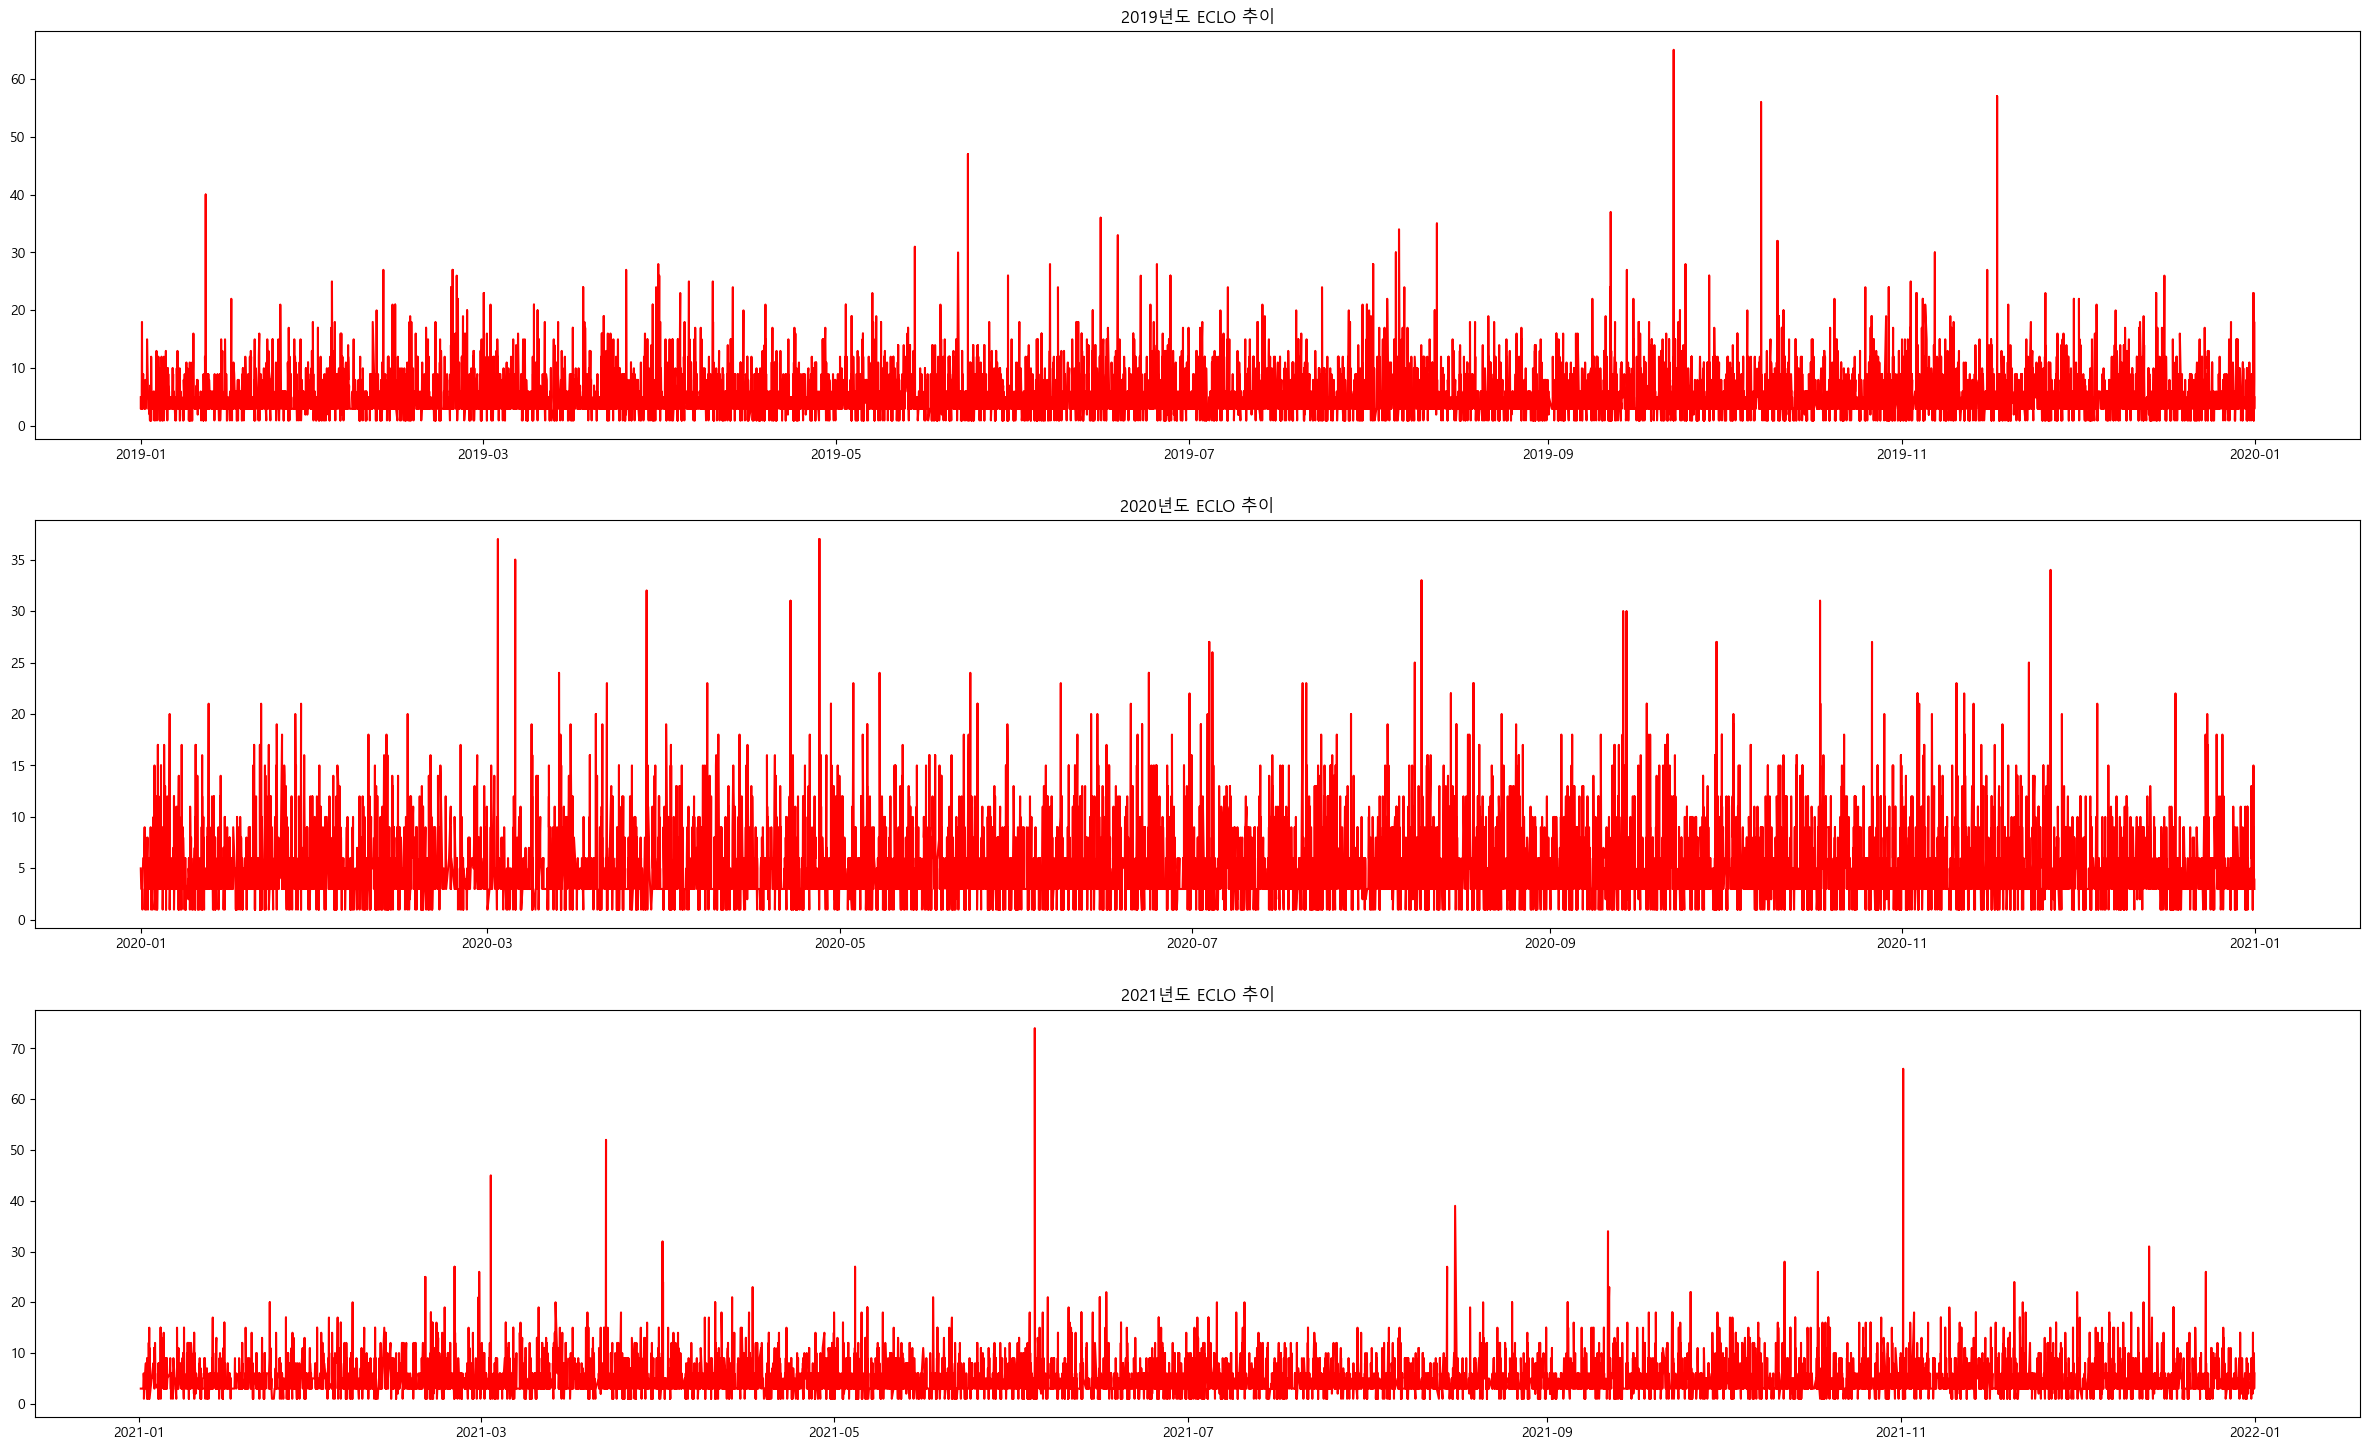

In [87]:
fig, axes = plt.subplots(figsize=(30,18), nrows=3, ncols=1)

plt.rcParams["font.family"] = "Malgun Gothic"

for i in range(2019, 2022) : 
    ax = axes[(i-2019)]
    year_eclo = df_train_join[df_train_join["사고일시"].dt.year==i]
    ax.plot(year_eclo["사고일시"], year_eclo["ECLO"], color="red")
    ax.set_title(str(i)+"년도 ECLO 추이")

plt.show()

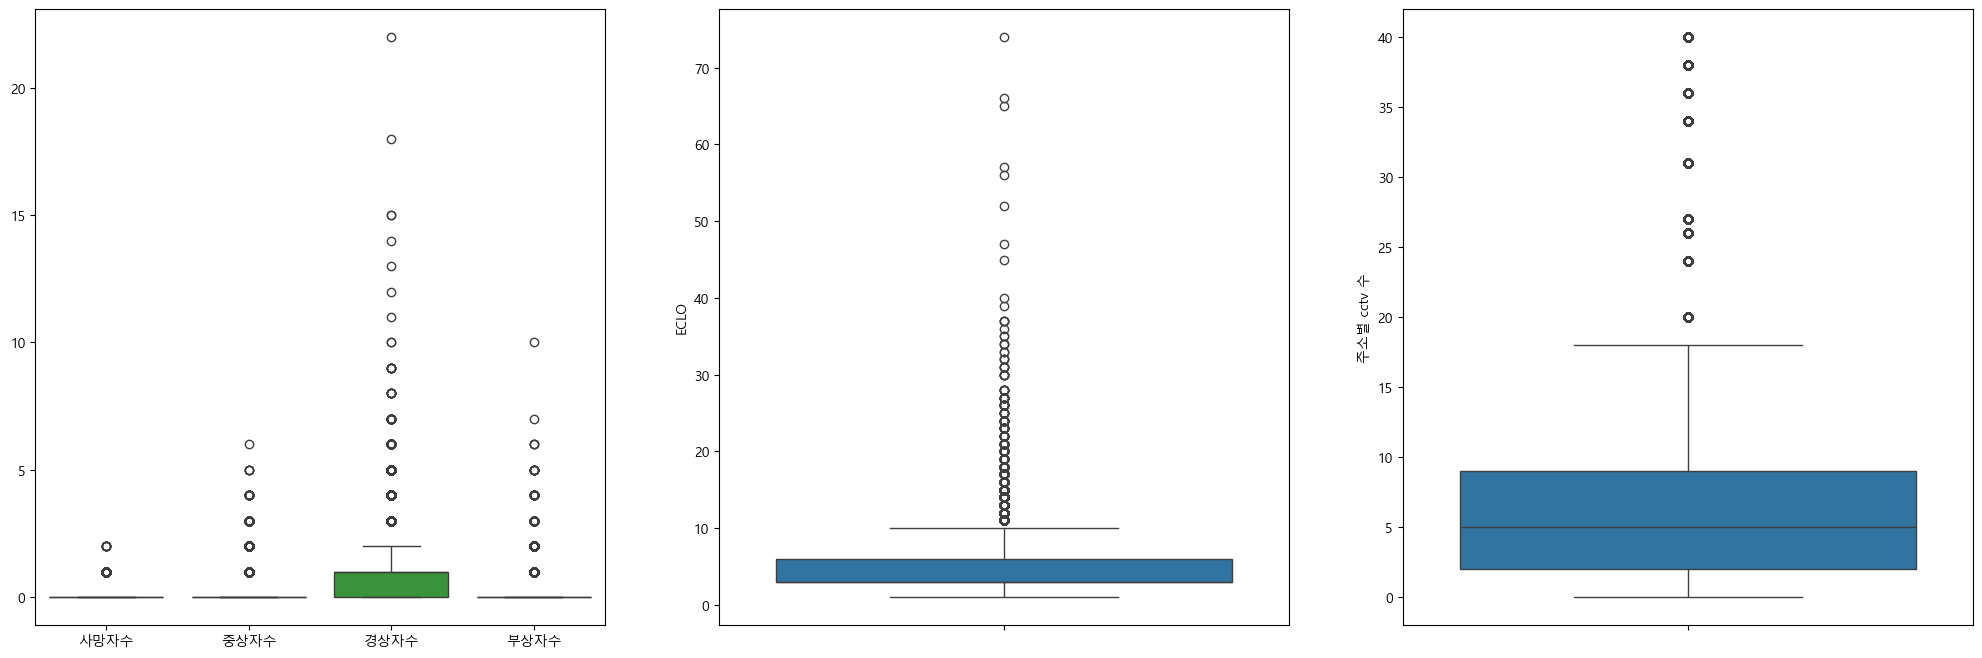

In [29]:
# 숫자 컬럼의 box-plot

fig, axes = plt.subplots(figsize=(25,8), nrows=1, ncols=3)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

add_infra = df_train_join.groupby("시군구")[["주소별 cctv 수"]].mean()

sns.boxplot(df_train_join.select_dtypes("number").iloc[:,0:4], ax=axes[0])
sns.boxplot(df_train_join.select_dtypes("number").iloc[:,4], ax=axes[1])
# sns.boxplot(add_infra[["주소별 cctv 수", "주소별 어린이 보호구역 수",'주소별 어린이 보호구역 cctv 수']], ax=axes[2])
sns.boxplot(df_train_join.select_dtypes("number").iloc[:,5], ax=axes[2])

plt.show()

"사망" 이란 교통사고 발생시로부터 30일이내에 사망한 경우. (99년까지는 72시간 이내)  
"중상" 이란 교통사고로 인하여 3주 이상의 치료를 요하는 부상을 입은 경우.  
"경상" 이란 교통사고로 인하여 5일 이상 3주 미만의 치료를 요하는 부상을 입은 경우.  
"부상신고" 란 교통사고로 인하여 5일 미만의 치료를 요하는 부상을 입은 경우.  

'측면 충돌'은 차가 옆에서 박은 것  
'추돌'은 뒤에서 박은 것(안전거리 미확보)  
'정면 추돌'은 앞에서 박은 것

---

사고에 따른 피해자 수를 살펴보면,  
  
사고에 따라 부상의 경우가 다르기 때문에 대부분의 값이 0인 경우를 알 수 있음(그렇기 때문에 피해자 수가 Q3 + 1.5iqr을 벗어나는 값이 많아 보임).  
  
그러나 차량의 수용 인원이나 주위의 유동 인구, 사고의 규모에 따라 피해자의 수가 달라짐을 확인할 수 있음.  
  
경상자의 경우 20명이 넘는 피해자가 있는 경우도 있는데, 아마 추돌 사고나 버스 등에 대형 차량에 의한 사고로 보임.  
  
**ECLO = 사망자수 * 10 + 중상자수 * 5 + 경상자수 * 3 + 부상자수 * 1**  
  
ECLO 식은 위와 같은데,  
  
데이터 분포의 75%까지 6의 값인 것을 유추해보면  
  
중상자 1.2명, 경상자 2명, 부상자 6명 등으로 생각할 수 있음.  
  
부상과 경상까지 생각한다면 75% 정도가 큰 사고가 아님을 알 수 있지만,  
  
중상과 경상만으로도 ECLO 값이 6을 초과할 수 있기 때문에  
  
Q3을 임의로 ECLO의 기준으로 삼음

---

교통 사고 예방을 위한 인프라의 수를 살펴봤을 때,  
  
대부분은 좌로 치우친 그래프를 확인할 수 있는데 이는 각 지역의 인구수나 소득 수준에 비례할 것이라고 생각한다.  
  
인구 수에 비례한다고 했을 때 인구 밀도가 높지 않은 지역 혹은, 차량의 유입이 없는 지역은 cctv가 없을 가능성이 크다.

---

object 타입의 데이터 분포를 시각화 하기 전에 사고 일시를 월과 시간대로 나눠  
  
계절과 시간대를 구분하려고 한다.

In [94]:
def season_time(dataframe) : 
    """
    사고 발생 시각을 범주화
    """

    dataframe["사고일시"] = pd.to_datetime(dataframe["사고일시"], format="%Y-%m-%d %H:%M:%S")

    dataframe["사고 연도"] = dataframe["사고일시"].dt.strftime("%Y").astype(int)
    dataframe["사고 월"] = dataframe["사고일시"].dt.strftime("%m").astype(int)
    dataframe["사고 시각"] = dataframe["사고일시"].dt.strftime("%H").astype(int)

    dataframe["사고 계절"] = 0
    dataframe["사고 시간대"] = 0

    for r in range(dataframe.shape[0]) : 

        # 각 사고 월을 계절로 치환
        if (dataframe.loc[r,"사고 월"] >= 3) & (dataframe.loc[r,"사고 월"] < 6) : 
            dataframe.loc[r,"사고 계절"] = "봄"
        elif (dataframe.loc[r,"사고 월"] >= 6) & (dataframe.loc[r,"사고 월"] < 9) : 
            dataframe.loc[r,"사고 계절"] = "여름"
        elif (dataframe.loc[r,"사고 월"] >= 9) & (dataframe.loc[r,"사고 월"] < 12) : 
            dataframe.loc[r,"사고 계절"] = "가을"
        else : 
            dataframe.loc[r,"사고 계절"] = "겨울"

        
        # 각 사고 시각을 시간대로 치환
        if (dataframe.loc[r,"사고 시각"] >= 0) & (dataframe.loc[r,"사고 시각"] < 6) : 
            dataframe.loc[r,"사고 시간대"] = "새벽"
        elif (dataframe.loc[r,"사고 시각"] >= 6) & (dataframe.loc[r,"사고 시각"] < 12) : 
            dataframe.loc[r,"사고 시간대"] = "아침"
        elif (dataframe.loc[r,"사고 시각"] >= 12) & (dataframe.loc[r,"사고 시각"] < 18) : 
            dataframe.loc[r,"사고 시간대"] = "점심"
        else : 
            dataframe.loc[r,"사고 시간대"] = "저녁"

    return dataframe

In [95]:
df_train_join = season_time(df_train_join)

df_train_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   사고일시         39609 non-null  datetime64[ns]
 1   요일           39609 non-null  object        
 2   기상상태         39609 non-null  object        
 3   시군구          39609 non-null  object        
 4   도로형태         39609 non-null  object        
 5   노면상태         39609 non-null  object        
 6   사고유형         39609 non-null  object        
 7   사고유형 - 세부분류  39609 non-null  object        
 8   법규위반         39609 non-null  object        
 9   가해운전자 차종     39609 non-null  object        
 10  가해운전자 성별     39609 non-null  object        
 11  가해운전자 연령     39609 non-null  object        
 12  가해운전자 상해정도   39609 non-null  object        
 13  피해운전자 차종     39609 non-null  object        
 14  피해운전자 성별     39609 non-null  object        
 15  피해운전자 연령     39609 non-null  object        
 16  피해운전

In [96]:
df_test_join = season_time(df_test_join)

df_test_join

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,주소별 cctv 수,사고 연도,사고 월,사고 시각,사고 계절,사고 시간대
0,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람,1.00000,2022,1,1,겨울,새벽
1,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람,4.00000,2022,1,1,겨울,새벽
2,2022-01-01 04:00:00,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차,1.00000,2022,1,4,겨울,새벽
3,2022-01-01 04:00:00,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차,7.00000,2022,1,4,겨울,새벽
4,2022-01-01 06:00:00,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차,11.00000,2022,1,6,겨울,아침
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,2022-12-31 18:00:00,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차,40.00000,2022,12,18,겨울,저녁
10959,2022-12-31 18:00:00,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차,1.00000,2022,12,18,겨울,저녁
10960,2022-12-31 20:00:00,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차,0,2022,12,20,겨울,저녁
10961,2022-12-31 20:00:00,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차,4.00000,2022,12,20,겨울,저녁


In [97]:
# 사고 월과 시각을 object 타입으로 변경

df_train_join[["사고 월", "사고 시각"]] = df_train_join[["사고 월", "사고 시각"]].astype(object)
df_test_join[["사고 월", "사고 시각"]] = df_test_join[["사고 월", "사고 시각"]].astype(object)

In [93]:
object_select = df_train_join.select_dtypes("object").drop(["가해운전자 연령", "피해운전자 연령", "시군구"], axis=1)  # object 타입의 컬럼만 추출

object_select

,요일,기상상태,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 상해정도,가해연령대,피해연령대,사고 월,사고 시각,사고 계절,사고 시간대
0,화요일,맑음,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,상해없음,보행자,여,중상,50대,60대,1,0,겨울,새벽
1,화요일,흐림,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,상해없음,보행자,남,경상,30대,60대,1,0,겨울,새벽
2,화요일,맑음,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,상해없음,보행자,남,경상,60대,30대,1,1,겨울,새벽
3,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,상해없음,승용,남,중상,40대,30대,1,2,겨울,새벽
4,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,상해없음,승용,남,경상,20대,50대,1,4,겨울,새벽
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,금요일,맑음,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,승용,여,상해없음,이륜,남,경상,50대,20대,12,19,겨울,저녁
39605,금요일,맑음,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,승용,여,상해없음,승용,남,경상,50대,50대,12,19,겨울,저녁
39606,금요일,맑음,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,승용,남,중상,승용,남,중상,50대,70대,12,21,겨울,저녁
39607,금요일,맑음,기타 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,상해없음,승용,여,경상,30대,50대,12,22,겨울,저녁


object 타입의 히스토그램을 살펴보면

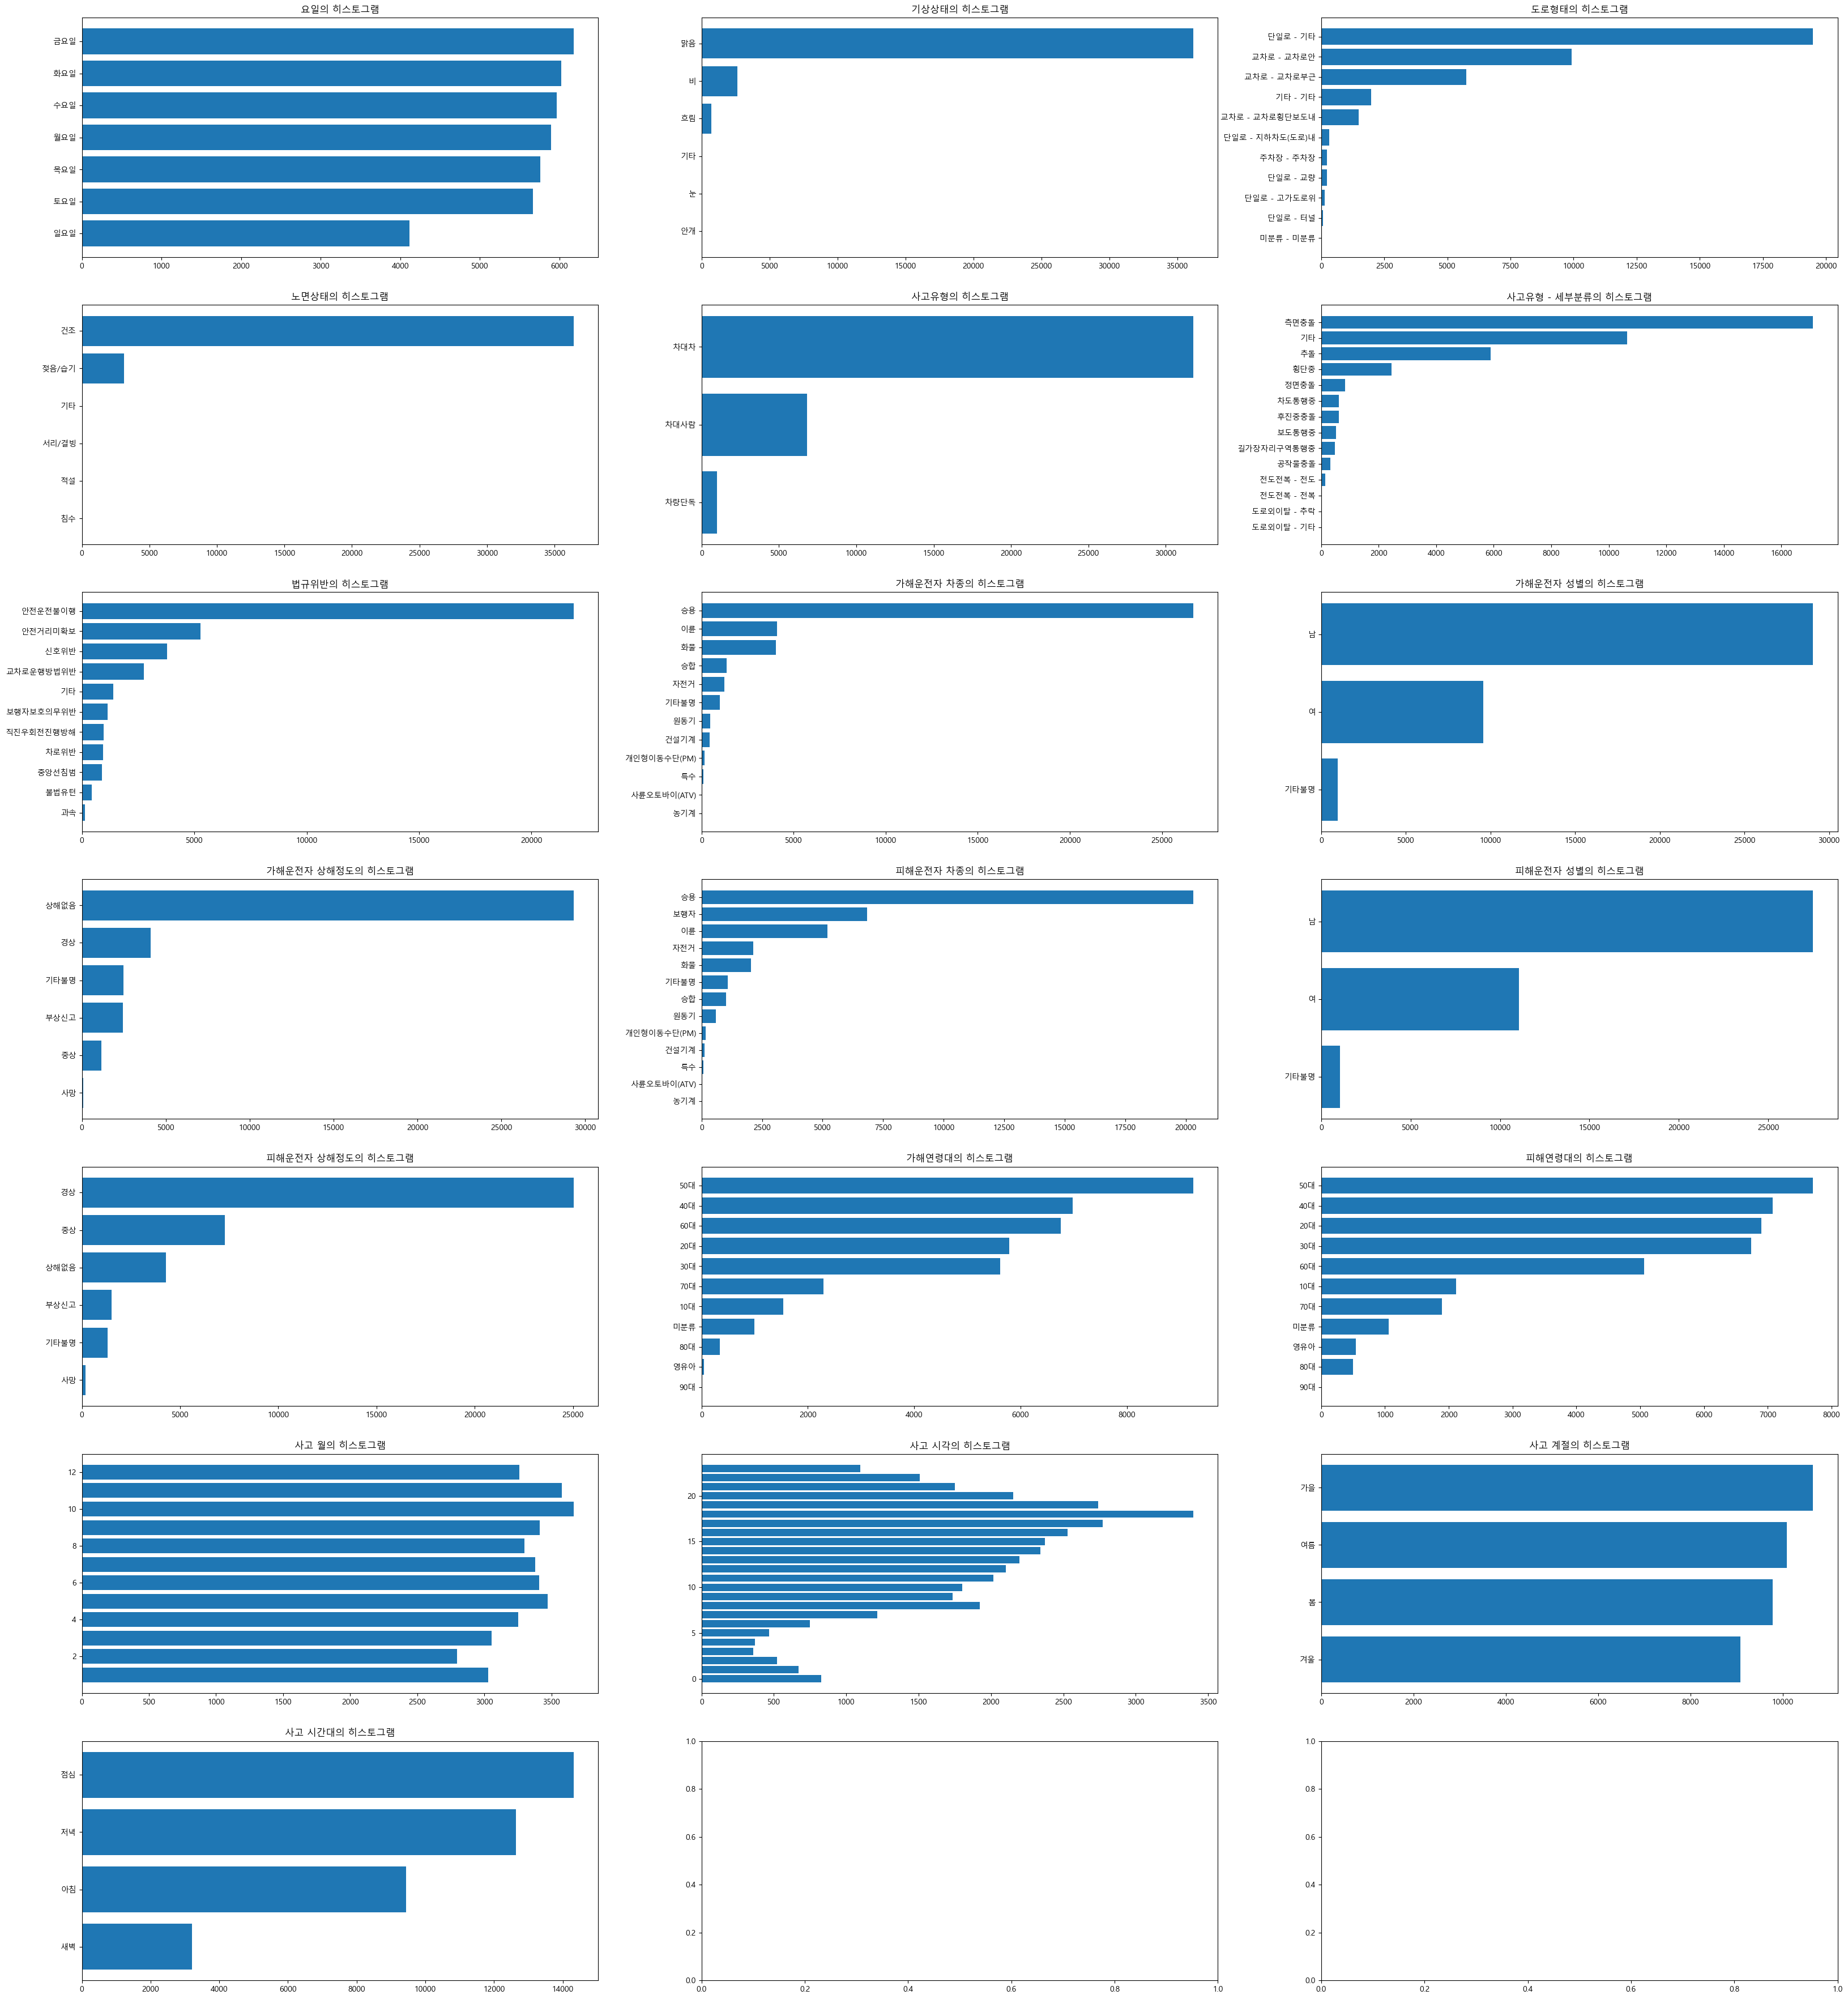

In [94]:
fig, axes = plt.subplots(figsize=(40,45), nrows=7, ncols=3)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

col_ob_sel = object_select.columns

for L in range(len(col_ob_sel)) : 
    ax = axes[L//3][L%3]
    obj = object_select.iloc[:,L].value_counts(ascending=True)
    # ax.hist(object_select.iloc[:,L], color="lightgreen", align="left")
    ax.barh(obj.index, obj)
    ax.set_title(col_ob_sel[L]+"의 히스토그램")

plt.show()

하나하나 살펴보면  
  
- 요일 : 일요일을 제외하면, 요일에 따른 사고는 큰 차이가 없어 보임
- 기상 상태 : 날씨가 안 좋을 때보다 날씨가 좋을 때 사고가 많이 일어남 >> 날씨가 안 좋아서 더욱 조심 or 날씨가 맑을 때 교통량이 많음
- 노면 상태 : 건조할 때 사고가 많음 >> 이는 기상 상태와 연관성을 보이므로 둘 중 하나의 변수 제거 고려
- 사고 유형 : '차대차'가 가장 많음
- 가해 운전자 차종 : 업무용 차보다 승용차가 압도적으로 많음 ↔ 화물이나 이륜도 어느 정도 비율을 차지
- 피해 운전자 차종 : 승용차가 많음 >> 사고가 차대차가 많기 때문
- 가해 운전자 / 피해 운전자 성별 : 남자가 많음 >> 해당 도시에 운전 면허를 가진 사람이 남자가 많을 가능성 ↔ 여성이 운전을 조금 더 조심하게 할 가능성
- 가해 운전자 / 피해 운전자 상해 정도 : 가해 운전자는 상해가 없을 수 있으나 피해 운전자는 경상을 입은 경우가 많음
- 사고 계절 : 계절별 큰 차이는 없으나, 가을이 가장 많고 겨울이 적은 것을 봤을 때 교통량의 차이로 보임
- 사고 시간대 : 새벽이 제일 적고 점심이 제일 많은 것으로 보아 교통량의 차이로 보임. 특히 17~19시가 많은 것을 보아 퇴근 시간대 사고 많이 나는 것으로 보임

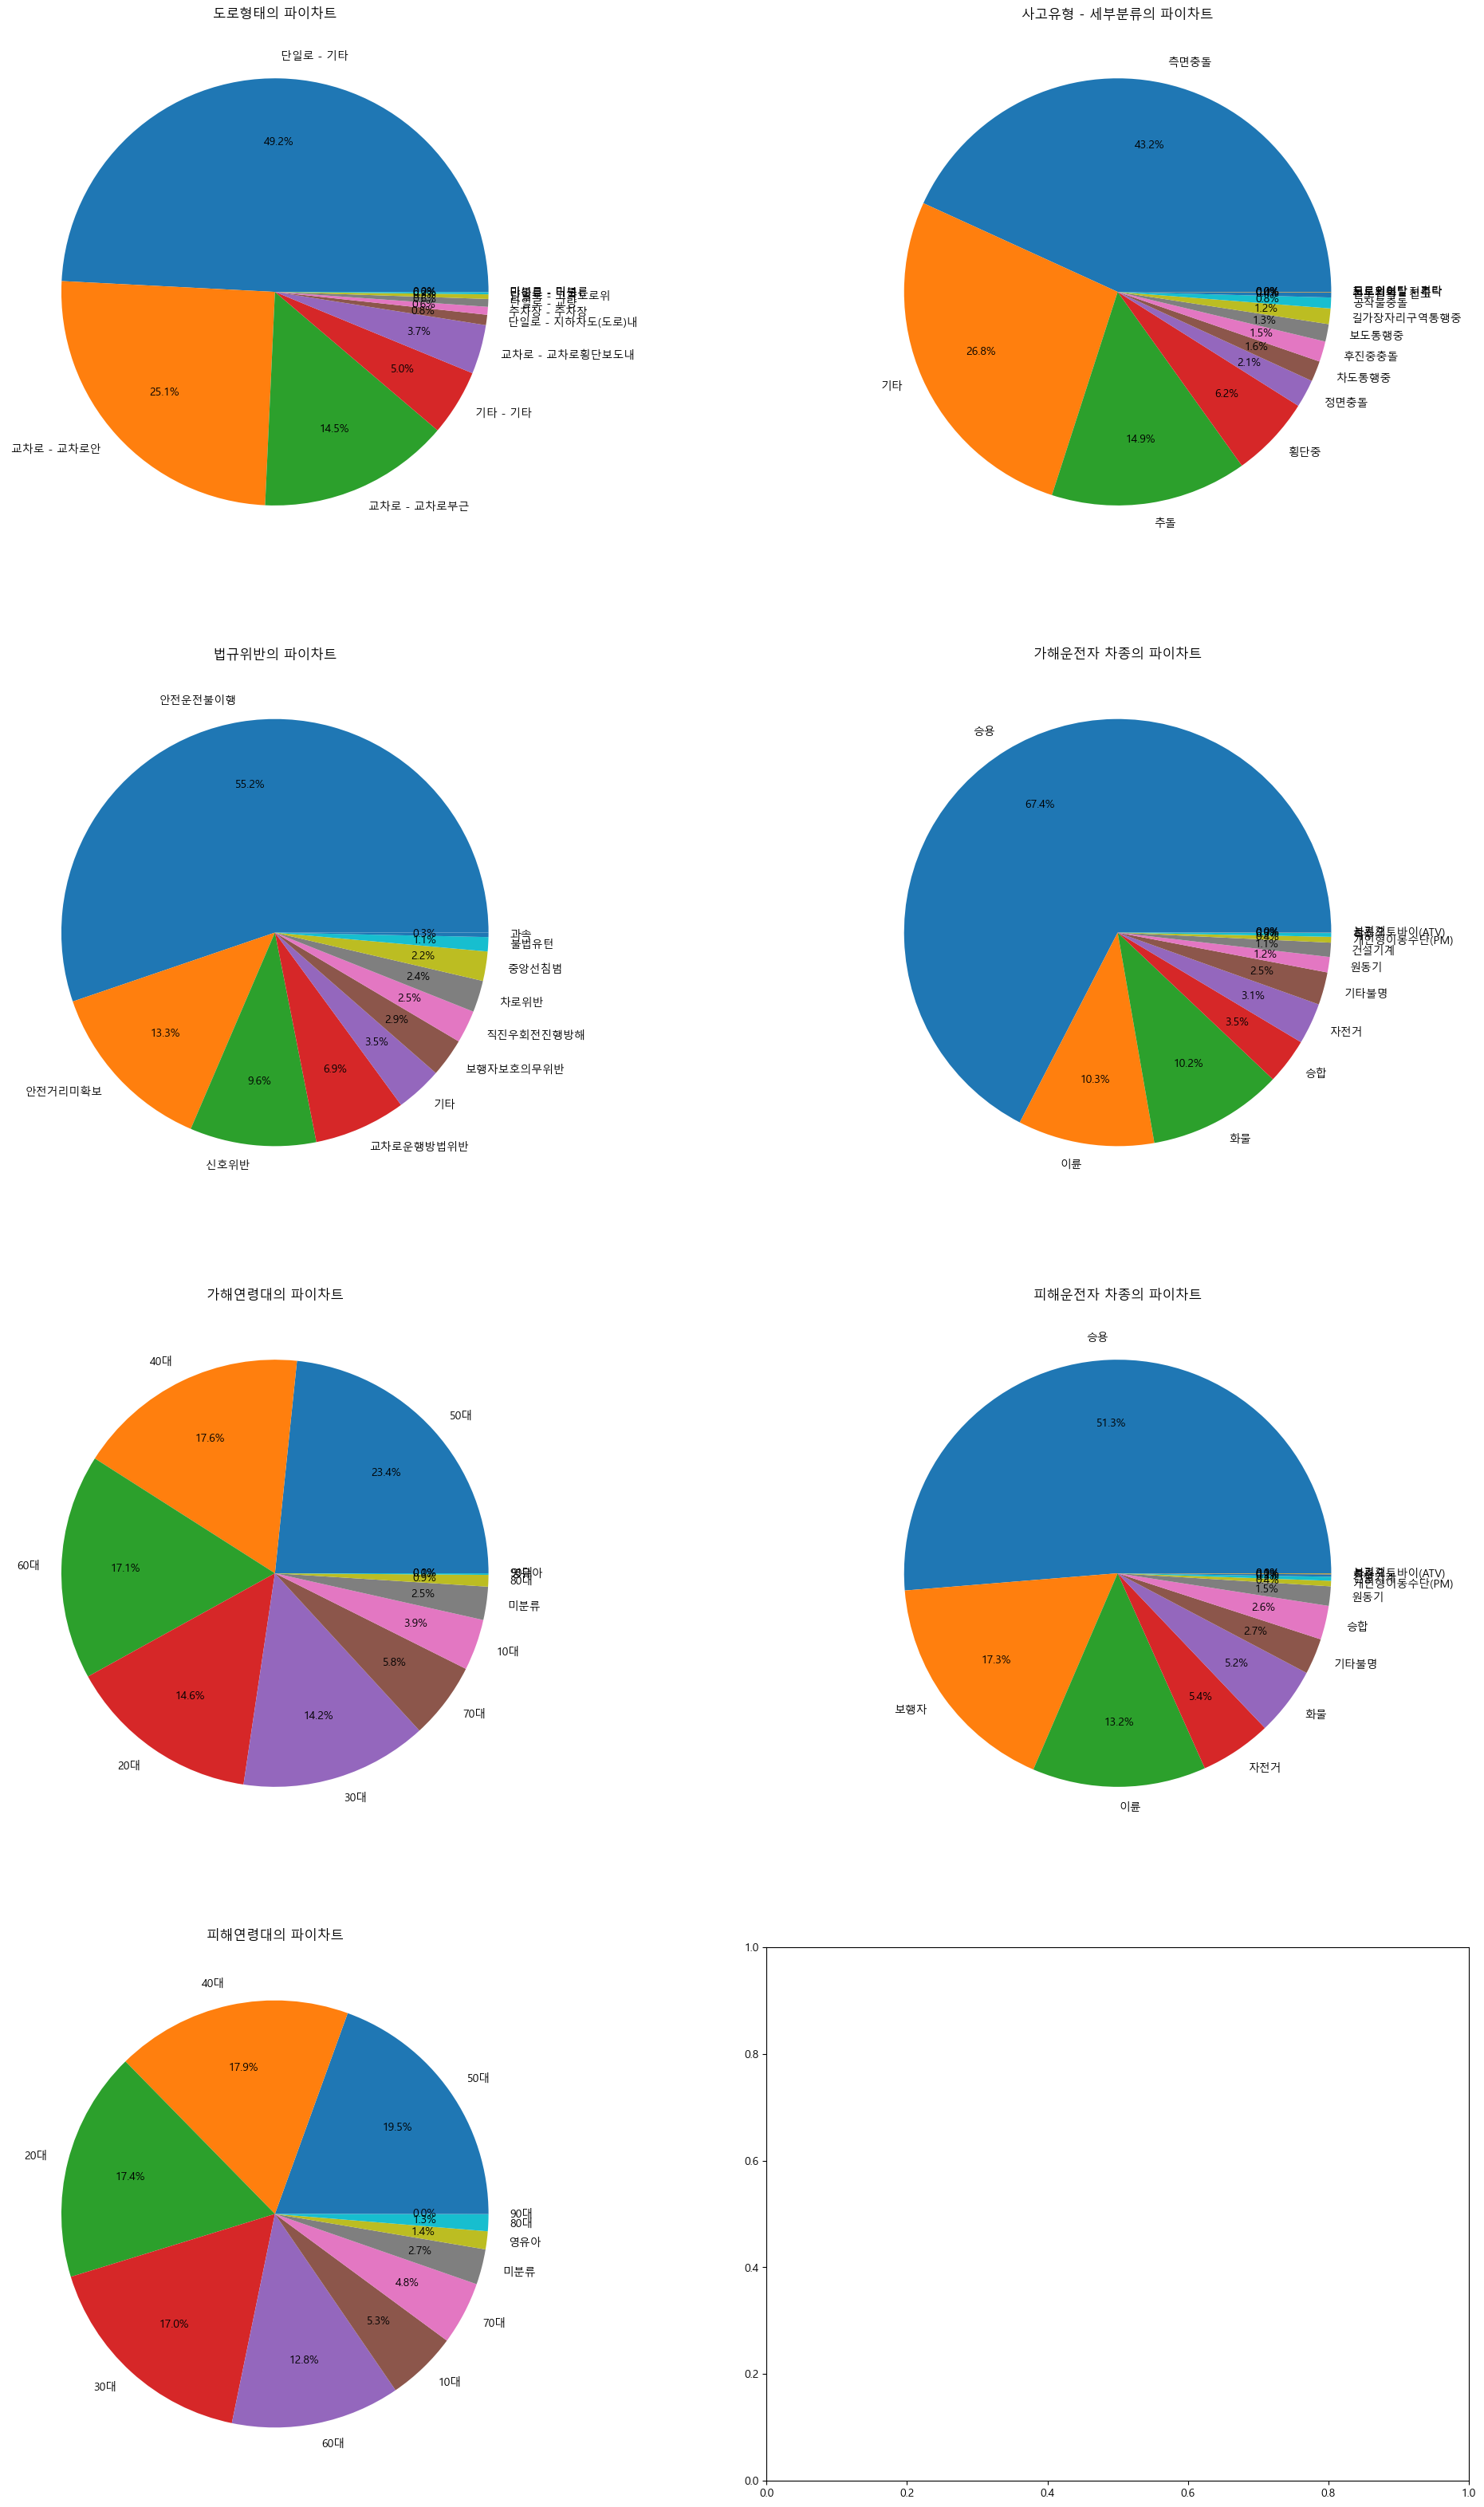

In [95]:
fig, axes = plt.subplots(figsize=(25,40), nrows=4, ncols=2)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

col_ob_sel = object_select.columns

List_pie = ['도로형태', '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해연령대', '피해운전자 차종', '피해연령대']

for L in range(len(List_pie)) : 
    ax = axes[L//2][L%2]

    val_cnt = df_train_join[List_pie[L]].value_counts()

    ax.pie(val_cnt, labels=val_cnt.index, pctdistance=0.7, autopct="%.1f%%")
    ax.set_title(List_pie[L]+"의 파이차트")
    # ax.legend(loc="upper right")

plt.show()

- 도로형태 : 단일로가 제일 많고, 그 다음 교차로 안이 두 번째로 사고가 많음
- 사고유형 - 세부분류 : 측면 충돌이 제일 많고, 기타가 2위, 추돌이 3위 >> 단일로나 교차로에서 측면 충돌이나 추돌이 일어날 가능성이 큼
- 법규위반 : 안전운전 불이행이 가장 많고, 안전거리 미확보가 그 다음  
(안전운전불이행 : 휴대전화, 담배, 라디오 조작, 졸음운전, 전방 주시 태만 사고, 제동장치 조작 불량 사고, 핸들 과대조작 사고 등)
- 가해 연령대 : 50대가 제일 많고 그 뒤로 40대, 60대 >> 차가 있을 확률이 높은 연령대가 사고를 많이 냄
- 피해 연령대 : 50대가 제일 많고 그 뒤로 40대, 20대

종합적으로  
  
1. 언제 : 여름이나 겨울, 퇴근 시간대
2. 어디서 : 단일로나 교차로
3. 누가 : 40~60대 남성
4. 무엇을 : 측면 충돌 혹은 추돌
5. 어떻게 : 안전 운전 불이행 혹은 안전 거리 미확보
6. 왜 : ??

같은 이유로 사고가 날 수 있음

### 카이제곱 검정

가해 운전자의 개인 정보를 알기는 어려우나,  
  
사고가 많이 나는 조건을 안다면,  
  
해당 지역에 사고가 날지 안 날지 예측할 수 있음

---

범주형 데이터들이 ECLO와 독립적인지 아닌지를 판단할 필요가 있음  
  
ECLO 기준은 임의로 설정함 

In [34]:
Q1 = df_train["ECLO"].quantile(0.25)
Q2 = df_train["ECLO"].quantile(0.5)
Q3 = df_train["ECLO"].quantile(0.75)

iqr = Q3 - Q1
Q_min = Q1 - (1.5 * iqr)
Q_max = Q3 + (1.5 * iqr)

print("1분위수 =", Q1)
print("중앙값 =", Q2)
print("3분위수 =", Q3)
print("iqr 계산을 통한 최소값 =", Q_min)
print("iqr 계산을 통한 최대값 =", Q_max)

1분위수 = 3.0
중앙값 = 3.0
3분위수 = 6.0
iqr 계산을 통한 최소값 = -1.5
iqr 계산을 통한 최대값 = 10.5


최소치는 음수이므로 고려하지 않고, 1분위수와 중앙값이 동일하므로  
  
1. ~ 중앙값
2. 중앙값 ~ 3분위
3. 3분위 ~ iqr 계산을 통한 최대값(10.5 >> 10으로 계산)
4. iqr 계산을 통한 최대값 ~  
  
총 4가지 범주로 나눠 생각함

In [35]:
def chi_obj(dataframe, col : str) : 

    chi_list = []
    
    q2 = 3
    q3 = 6
    qmax = 10

    uni = dataframe[col].unique()

    for u in uni : 

        obj_list = []

        for i in range(4) : 
            if i==0 : 
                cnt = dataframe[(dataframe["ECLO"] <= 3) & (dataframe[col] == u)][col].shape[0]
                obj_list.append(cnt)
            elif i==1 : 
                cnt = dataframe[(dataframe["ECLO"] > 3) & (dataframe["ECLO"] <= 6) & (dataframe[col] == u)][col].shape[0]
                obj_list.append(cnt)
            elif i==2 : 
                cnt = dataframe[(dataframe["ECLO"] > 6) & (dataframe["ECLO"] <= 10) & (dataframe[col] == u)][col].shape[0]
                obj_list.append(cnt)
            else : 
                cnt = dataframe[(dataframe["ECLO"] > 10) & (dataframe[col] == u)][col].shape[0]
                obj_list.append(cnt)

        chi_list.append(obj_list)

    chi = np.array(chi_list)   # 성별에 따른 사고를 낸 사람과 내지 않은 사람을 구분

    print(chi)

    result = chi2_contingency(chi)
    
    print("p-value :",result[1])

    if result[1] <= 0.05 : 
        print("유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, "+col+"은 ECLO와 독립적이라고 말할 수 없습니다.")
    else : 
        print("유의수준 5%에서 p-value가 0.05보다 작지않으므로 귀무가설 채택, "+col+"은 ECLO와 독립적입니다.")

In [36]:
chi_obj(dataframe=df_train_join, col="요일")

[[3315 1916  505  287]
 [3274 1906  511  278]
 [3225 1783  502  249]
 [3438 1917  534  290]
 [2954 1769  578  369]
 [1988 1333  445  348]
 [3209 1904  479  303]]
p-value : 9.056269961826512e-31
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 요일은 ECLO와 독립적이라고 말할 수 없습니다.


In [37]:
chi_obj(dataframe=df_train_join, col="기상상태")

[[19598 11436  3258  1889]
 [  384   242    55    48]
 [   25    21     6     4]
 [ 1388   824   233   182]
 [    3     4     0     1]
 [    5     1     2     0]]
p-value : 0.0260667935690098
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 기상상태은 ECLO와 독립적이라고 말할 수 없습니다.


In [38]:
chi_obj(dataframe=df_train_join, col="도로형태")

[[10912  5949  1611  1013]
 [ 4844  3300  1146   641]
 [ 1239   597   115    35]
 [   28    13    10    13]
 [  175    96    27    11]
 [  115    76    28    13]
 [  788   594    68    24]
 [  165    57    11     3]
 [ 3065  1806   518   357]
 [   67    37    20    14]
 [    5     3     0     0]]
p-value : 3.5279063360438857e-82
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 도로형태은 ECLO와 독립적이라고 말할 수 없습니다.


In [39]:
chi_obj(dataframe=df_train_join, col="노면상태")

[[19723 11506  3286  1905]
 [ 1630   990   264   216]
 [   13     9     2     1]
 [   33    22     1     2]
 [    1     1     1     0]
 [    3     0     0     0]]
p-value : 0.020681910643964
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 노면상태은 ECLO와 독립적이라고 말할 수 없습니다.


In [40]:
chi_obj(dataframe=df_train_join, col="사고유형")

[[ 4120  2459   227    27]
 [16684  9774  3256  2071]
 [  599   295    71    26]]
p-value : 1.7779282583197334e-176
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 사고유형은 ECLO와 독립적이라고 말할 수 없습니다.


In [41]:
chi_obj(dataframe=df_train_join, col="사고 월")

[[1627 1002  248  153]
 [1513  864  253  166]
 [1591  984  302  175]
 [1717 1036  317  181]
 [1878 1126  300  170]
 [1885 1034  295  193]
 [1837 1044  316  184]
 [1791 1027  312  170]
 [1890 1032  303  188]
 [1963 1204  301  198]
 [1875 1149  350  203]
 [1836 1026  257  143]]
p-value : 0.02077184994107009
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 사고 월은 ECLO와 독립적이라고 말할 수 없습니다.


In [42]:
chi_obj(dataframe=df_train_join, col="사고 계절")

[[4976 2892  758  462]
 [5186 3146  919  526]
 [5513 3105  923  547]
 [5728 3385  954  589]]
p-value : 0.08473435791907419
유의수준 5%에서 p-value가 0.05보다 작지않으므로 귀무가설 채택, 사고 계절은 ECLO와 독립적입니다.


In [43]:
chi_obj(dataframe=df_train_join, col="사고 시각")

[[ 413  244  113   58]
 [ 321  205   82   61]
 [ 233  167   76   44]
 [ 168  137   32   30]
 [ 219  153   64   31]
 [ 370  281   69   30]
 [ 984  598  140   81]
 [1114  640  167   95]
 [1312  722  202  106]
 [1909 1056  268  165]
 [1487  882  236  134]
 [1191  656  198  109]
 [ 787  467  147  105]
 [ 636  419   99   59]
 [1067  599  163   95]
 [1226  648  215  109]
 [1287  738  215  134]
 [1401  787  204  137]
 [1552  857  227  136]
 [ 538  367  129   62]
 [ 165  112   41   38]
 [1149  669  174  112]
 [ 907  565  175  102]
 [ 967  559  118   91]]
p-value : 9.311187535697249e-24
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 사고 시각은 ECLO와 독립적이라고 말할 수 없습니다.


In [44]:
chi_obj(dataframe=df_train_join, col="사고 시간대")

[[1519 1018  408  262]
 [5138 3096  756  451]
 [7927 4421 1237  734]
 [6819 3993 1153  677]]
p-value : 9.06553275291412e-29
유의수준 5%에서 p-value가 0.05보다 작으므로 귀무가설 기각, 대립가설 채택, 사고 시간대은 ECLO와 독립적이라고 말할 수 없습니다.


사고가 난 뒤 알 수 있는 정보(가해 운전자와 피해 운전자의 정보)는 미래에 대한 정보이므로 학습에 사용할 수 없습니다.  
  
그 이외의 범주형 데이터를 살펴봤을 때,  
  
사고 계절을 제외하고는  
  
전부 ECLO와 독립적이지 않다고 가정할 수 있는데  
  
특이한 점은 사고가 발생한 계절로 크게 범주화했을 때는 ECLO와 독립적이지만,  
  
월 단위로 봤을 때는 유의하다는 것입니다.  
  
대구라는 지역의 날씨나 행사 혹은 여러 요인이 영향을 미칠 수 있다고 볼 수 있습니다.  
  
사고 계절은 변수에서 제거하겠습니다.

In [98]:
# 사고 계절 제거

df_train_join.drop("사고 계절", axis=1, inplace=True)

df_test_join.drop("사고 계절", axis=1, inplace=True)

### 상관성 검정

날씨와 노면 상태, cctv 수, 어린이 보호구역의 수, 어린이 보호구역의 cctv 수, 보안등 수에 따른 ECLO의 상관 계수를 확인.  
  
먼저 날씨는 맑을 때를 1, 흐릴 때를 2, 비 / 안개 /눈을 3으로 설정(날씨가 가혹할수록 가중).  
  
'기타'의 날씨를 가늠할 수 없으므로, 적당한 순위인 '흐림'가 동등하게 설정('기타'=2).
  
노면은 건조를 1, 젖음/습기를 2, 서리/결빙을 3, 침수와 적설을 4로 설정.  
  
서리/결빙을 젖음/습기보다 높게 설정한 이유는  
  
대구/경북 지역은 온도가 높아 추위 관련 재해에 취약하다고 판단했기 때문.  
  
노면 상태의 '기타'도 날씨와 같은 이유로 2로 설정

In [99]:
# 기상상태(날씨) 라벨링

df_train_join["기상상태_label"] = df_train_join["기상상태"].replace(["맑음", "흐림", '기타', '비', '안개', '눈'], [1,2,2,3,3,3])
df_test_join["기상상태_label"] = df_test_join["기상상태"].replace(["맑음", "흐림", '기타', '비', '안개', '눈'], [1,2,2,3,3,3])

df_train_join["기상상태_label"].value_counts()

기상상태_label
1    36181
3     2643
2      785
Name: count, dtype: int64

In [100]:
# 노면 상태 라벨링

df_train_join["노면상태_label"] = df_train_join["노면상태"].replace(['건조', '기타', '젖음/습기', '서리/결빙', '침수', '적설'],[1,2,2,3,3,3])
df_test_join["노면상태_label"] = df_test_join["노면상태"].replace(['건조', '기타', '젖음/습기', '서리/결빙', '침수', '적설'],[1,2,2,3,3,3,])

df_test_join["노면상태_label"].value_counts()

노면상태_label
1    10394
2      559
3       10
Name: count, dtype: int64

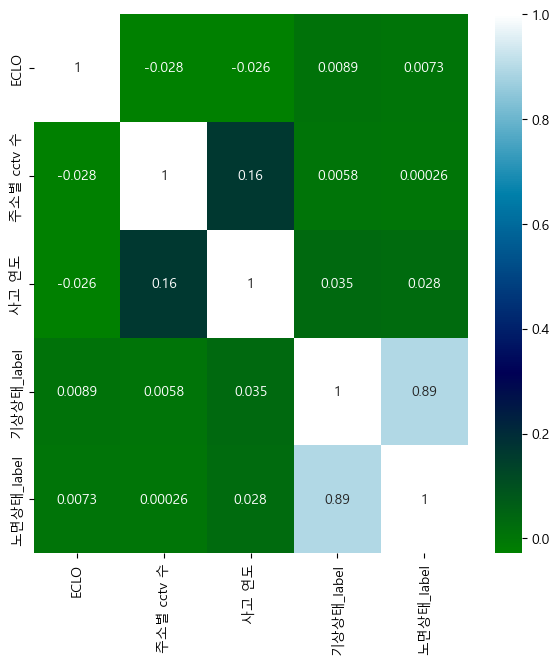

In [48]:
# 숫자 타입의 컬럼만 추출후 상관 관계 분석
# 순위 척도가 포함돼 있으므로 스피어만 상관 계수 사용

number_select = df_train_join.select_dtypes("number").drop(['사망자수','중상자수','경상자수','부상자수'], axis=1)

number_select_corr = number_select.corr("spearman")

plt.figure(figsize=(7,7))
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.family"] = "Malgun Gothic"

sns.heatmap(number_select_corr, annot=True, cmap='ocean')

plt.show()

기상상태_label - 노면상태_label(0.89) : 기상 상태가 안 좋으면 노면 상태도 안 좋을 것이기 때문에, 둘 사이의 강한 양의 상관 관계 → 둘 중 하나 제거 고려

## 모델링

In [101]:
X = df_train_join[df_test_join.columns]

X.drop(["기상상태", "노면상태", "사고 시각"], axis=1, inplace=True)

X.set_index('사고일시', inplace=True)

X.head()

,요일,시군구,도로형태,사고유형,주소별 cctv 수,사고 연도,사고 월,사고 시간대,기상상태_label,노면상태_label
사고일시,,,,,,,,,,
2019-01-01 00:00:00,화요일,대구광역시 중구 대신동,단일로 - 기타,차대사람,3,2019,1,새벽,1,1
2019-01-01 00:00:00,화요일,대구광역시 달서구 감삼동,단일로 - 기타,차대사람,9,2019,1,새벽,2,1
2019-01-01 01:00:00,화요일,대구광역시 수성구 두산동,단일로 - 기타,차대사람,2,2019,1,새벽,1,1
2019-01-01 02:00:00,화요일,대구광역시 북구 복현동,단일로 - 기타,차대차,5,2019,1,새벽,1,1
2019-01-01 04:00:00,화요일,대구광역시 동구 신암동,단일로 - 기타,차대차,6,2019,1,새벽,1,1


In [111]:
y = df_train[["사고일시", "ECLO"]].set_index("사고일시")

y

,ECLO
사고일시,
2019-01-01 00:00:00,5
2019-01-01 00:00:00,3
2019-01-01 01:00:00,3
2019-01-01 02:00:00,5
2019-01-01 04:00:00,3
...,...
2021-12-31 19:00:00,3
2021-12-31 19:00:00,3
2021-12-31 21:00:00,10


In [102]:
df_test_join.drop(["기상상태", "노면상태", "사고 시각"], axis=1, inplace=True)

df_test_join.set_index('사고일시', inplace=True)

df_test_join.head()

,요일,시군구,도로형태,사고유형,주소별 cctv 수,사고 연도,사고 월,사고 시간대,기상상태_label,노면상태_label
사고일시,,,,,,,,,,
2022-01-01 01:00:00,토요일,대구광역시 수성구 상동,교차로 - 교차로안,차대사람,1.00000,2022,1,새벽,1,1
2022-01-01 01:00:00,토요일,대구광역시 수성구 지산동,단일로 - 기타,차대사람,4.00000,2022,1,새벽,1,1
2022-01-01 04:00:00,토요일,대구광역시 수성구 수성동2가,교차로 - 교차로안,차대차,1.00000,2022,1,새벽,1,1
2022-01-01 04:00:00,토요일,대구광역시 수성구 신매동,단일로 - 기타,차대차,7.00000,2022,1,새벽,1,1
2022-01-01 06:00:00,토요일,대구광역시 달서구 감삼동,교차로 - 교차로안,차대차,11.00000,2022,1,아침,1,1


In [103]:
def delete_si(dataframe) : 

    dataframe_c = copy.deepcopy(dataframe)

    dataframe_c.replace("대구광역시 " , "", regex=True, inplace=True)

    dataframe_c["군구"] = dataframe_c["시군구"].str.split().apply(lambda x : x[0])

    dataframe_c["읍면동"] = dataframe_c["시군구"].str.split().apply(lambda x : x[1])

    dataframe_c.drop("시군구", axis=1, inplace=True)

    return dataframe_c

In [104]:
X = delete_si(X)

test = delete_si(df_test_join)

test

,요일,도로형태,사고유형,주소별 cctv 수,사고 연도,사고 월,사고 시간대,기상상태_label,노면상태_label,군구,읍면동
사고일시,,,,,,,,,,,
2022-01-01 01:00:00,토요일,교차로 - 교차로안,차대사람,1.00000,2022,1,새벽,1,1,수성구,상동
2022-01-01 01:00:00,토요일,단일로 - 기타,차대사람,4.00000,2022,1,새벽,1,1,수성구,지산동
2022-01-01 04:00:00,토요일,교차로 - 교차로안,차대차,1.00000,2022,1,새벽,1,1,수성구,수성동2가
2022-01-01 04:00:00,토요일,단일로 - 기타,차대차,7.00000,2022,1,새벽,1,1,수성구,신매동
2022-01-01 06:00:00,토요일,교차로 - 교차로안,차대차,11.00000,2022,1,아침,1,1,달서구,감삼동
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,토요일,단일로 - 터널,차대차,40.00000,2022,12,저녁,1,1,남구,대명동
2022-12-31 18:00:00,토요일,단일로 - 기타,차대차,1.00000,2022,12,저녁,1,1,수성구,시지동
2022-12-31 20:00:00,토요일,단일로 - 기타,차대차,0.00000,2022,12,저녁,1,1,수성구,연호동


### 범주형 변수를 LabelBinary

In [105]:
obj_columns = X.select_dtypes("object").columns

obj_columns

Index(['요일', '도로형태', '사고유형', '사고 시간대', '군구', '읍면동'], dtype='object')

In [106]:
def label_bin(column) : 
    """
    범주형 변수를 전부 one-hot-encoding
    """
    lb = LabelBinarizer()
    
    array = lb.fit_transform(column)
    
    classes = lb.classes_.tolist()
        
    classes_col = [column.name+"_"+c for c in classes]
    
    df_lb = pd.DataFrame(data=array, columns=classes_col)
    
    return df_lb, lb, classes_col

In [107]:
obj_day, lb_day, class_day = label_bin(X["요일"])
obj_doro, lb_doro, class_doro = label_bin(X["도로형태"])
obj_sago, lb_sago, class_sago = label_bin(X["사고유형"])
obj_sago_time, lb_sago_time, class_sago_time = label_bin(X["사고 시간대"])
obj_gg, lb_gg, class_gg = label_bin(X["군구"])
obj_emd, lb_emd, class_emd = label_bin(X["읍면동"])

obj_day_test = pd.DataFrame(lb_day.transform(test["요일"]), columns=class_day)
obj_doro_test = pd.DataFrame(lb_doro.transform(test["도로형태"]), columns=class_doro)
obj_sago_test = pd.DataFrame(lb_sago.transform(test["사고유형"]), columns=class_sago)
obj_sago_time_test = pd.DataFrame(lb_sago_time.transform(test["사고 시간대"]), columns=class_sago_time)
obj_gg_test = pd.DataFrame(lb_gg.transform(test["군구"]), columns=class_gg)
obj_emd_test = pd.DataFrame(lb_emd.transform(test["읍면동"]), columns=class_emd)


obj_onehot_train = pd.concat([obj_day, obj_doro, obj_sago, obj_sago_time, obj_gg, obj_emd], axis=1)
obj_onehot_test = pd.concat([obj_day_test, obj_doro_test, obj_sago_test, obj_sago_time_test, obj_gg_test, obj_emd_test], axis=1)

print(obj_onehot_train.shape)
print(obj_onehot_test.shape)

obj_onehot_train.head()

(39609, 229)
(10963, 229)


,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,도로형태_교차로 - 교차로부근,도로형태_교차로 - 교차로안,도로형태_교차로 - 교차로횡단보도내,...,읍면동_하서동,읍면동_학정동,읍면동_향촌동,읍면동_현풍읍,읍면동_호림동,읍면동_호산동,읍면동_화원읍,읍면동_화전동,읍면동_황금동,읍면동_효목동
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
obj_onehot_train.set_index(X.index, inplace=True)
obj_onehot_test.set_index(test.index, inplace=True)

obj_onehot_train.head()

,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,도로형태_교차로 - 교차로부근,도로형태_교차로 - 교차로안,도로형태_교차로 - 교차로횡단보도내,...,읍면동_하서동,읍면동_학정동,읍면동_향촌동,읍면동_현풍읍,읍면동_호림동,읍면동_호산동,읍면동_화원읍,읍면동_화전동,읍면동_황금동,읍면동_효목동
사고일시,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 00:00:00,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 01:00:00,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 02:00:00,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 04:00:00,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
X.drop(obj_columns, axis=1, inplace=True)

X = pd.concat([X, obj_onehot_train], axis=1)

test.drop(obj_columns, axis=1, inplace=True)

test = pd.concat([test, obj_onehot_test], axis=1)

print(X.shape)
print(test.shape)

(39609, 234)
(10963, 234)


In [136]:
X.drop("사고 연도", axis=1,inplace=True)
test.drop("사고 연도", axis=1,inplace=True)

### train - validation 분리

In [112]:
def train_test(x, y, random_state : int) : 
    X_t, X_v, y_t, y_v = train_test_split(x, y, test_size=0.2, random_state=random_state)

    print(X_t.shape)
    print(X_v.shape)
    print(y_t.shape)
    print(y_v.shape)

    return X_t, X_v, y_t, y_v

In [137]:
X_train, X_val, y_train, y_val = train_test(X, y, random_state=randomState)

(31687, 233)
(7922, 233)
(31687, 1)
(7922, 1)


In [12]:
X_train = X.iloc[:31687]
X_val = X.iloc[31687:]
y_train = y.iloc[:31687]
y_val = y.iloc[31687:]

# X_train_cat = X_cat.iloc[:31687].select_dtypes("object")
# X_val_cat = X_cat.iloc[31687:].select_dtypes("object")
# y_train_cat = y.iloc[:31687]
# y_val_cat = y.iloc[31687:]

# X_train = X.iloc[:31687]
# X_val = X.iloc[31687:]
# y_train = y_log.iloc[:31687]
# y_val = y_log.iloc[31687:]

### smogn

In [24]:
data_smogn = copy.deepcopy(X_train)
data_smogn["ECLO"] = y_train["ECLO"].values
data_smogn.reset_index(drop=True,inplace=True)

# data_smogn

smogn_ba = smoter(
    data = data_smogn, 
    y = "ECLO",
    k = 5,   # 참고할 이웃의 수
    samp_method = "balance",   # oversampling을 적당하게 하겠다는 의미
    rel_thres = 0.7,   # sampling threshold 기준
    rel_method="auto"
)


r_index: 100%|##########| 2347/2347 [00:03<00:00, 624.32it/s]


(31687, 14)
(27188, 14)
(31687, 1)
(27188,)


<Axes: xlabel='ECLO', ylabel='Density'>

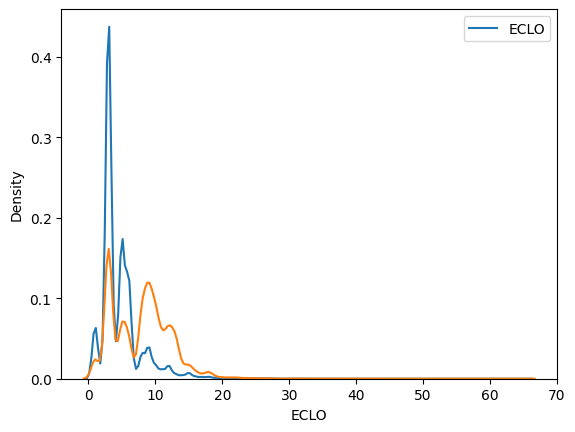

In [25]:
# smogn ('balance')을 적용한 train data 확인

y_train_smogn_ba = smogn_ba["ECLO"]

X_train_smogn_ba = smogn_ba.drop("ECLO", axis=1)

print(X_train.shape)
print(X_train_smogn_ba.shape)
print(y_train.shape)
print(y_train_smogn_ba.shape)

sns.kdeplot(y_train, label = "Original")
sns.kdeplot(y_train_smogn_ba, label = "Modified")

In [13]:
smogn_ex = smoter(
    data = data_smogn, 
    y = "ECLO",
    k = 5,   # 참고할 이웃의 수
    samp_method = "extreme",   # oversampling을 적당하게 하겠다는 의미
    rel_thres = 0.7,   # sampling threshold 기준
    rel_method="auto"
)

synth_matrix: 100%|##########| 4499/4499 [00:37<00:00, 121.08it/s]


(31687, 14)
(48745, 14)
(31687, 1)
(48745,)


<Axes: xlabel='ECLO', ylabel='Density'>

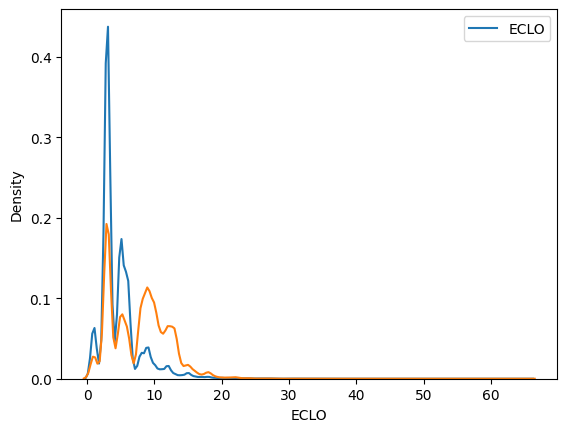

In [14]:
# smogn ('extreme')을 적용한 train data 확인

y_train_smogn = smogn_ex["ECLO"]

X_train_smogn = smogn_ex.drop("ECLO", axis=1)

print(X_train.shape)
print(X_train_smogn.shape)
print(y_train.shape)
print(y_train_smogn.shape)

sns.kdeplot(y_train, label = "Original")
sns.kdeplot(y_train_smogn, label = "Modified")

In [10]:
X_one = pd.concat([X.drop(["요일", "기상상태_label", "노면상태_label", "사고유형", "도로형태"], axis=1).reset_index(), obj_onehot_train], axis=1)
test_one = pd.concat([test.drop(["요일", "기상상태_label", "노면상태_label", "사고유형", "도로형태"], axis=1).reset_index(), obj_onehot_test], axis=1)

X_one.set_index("사고일시", inplace=True)
test_one.set_index("사고일시", inplace=True)

X_train_one = X_one.iloc[:31687]
X_val_one = X_one.iloc[31687:]
y_train_one = y.iloc[:31687]
y_val_one = y.iloc[31687:]

print(X_train_one.shape)
print(X_val_one.shape)
print(y_train_one.shape)
print(y_val_one.shape)

X_train_one

(31687, 42)
(7922, 42)
(31687, 1)
(7922, 1)


,주소별 cctv 수,사고 월,사고 시각,사고시간대 밀도 합,평균속도_max,추정교통량_mean,추정교통량_승용차_mean,추정교통량_버스_mean,추정교통량_트럭_mean,요일_금요일,...,도로형태_단일로 - 고가도로위,도로형태_단일로 - 교량,도로형태_단일로 - 기타,도로형태_단일로 - 지하차도(도로)내,도로형태_단일로 - 터널,도로형태_미분류 - 미분류,도로형태_주차장 - 주차장,사고유형_차대사람,사고유형_차대차,사고유형_차량단독
사고일시,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,3,1,0,312.06683,723.99000,549258.22000,474724.12000,32891.89000,41642.21000,0,...,0,0,1,0,0,0,0,1,0,0
2019-01-01 00:00:00,10,1,0,1022.36378,2142.80000,1812718.27000,1544309.56000,105449.71000,162959.00000,0,...,0,0,1,0,0,0,0,1,0,0
2019-01-01 01:00:00,2,1,1,561.03238,1932.21000,1073433.20000,950354.81000,52940.10000,70138.25000,0,...,0,0,1,0,0,0,0,1,0,0
2019-01-01 02:00:00,6,1,2,254.98900,1775.36000,1184141.76000,928212.11000,91811.50000,164118.15000,0,...,0,0,1,0,0,0,0,0,1,0
2019-01-01 04:00:00,9,1,4,434.11503,3768.83000,2040952.08000,1684317.26000,152959.33000,203675.47000,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-08 12:00:00,12,5,12,1870.10763,2664.83000,1287237.17000,1026239.88000,62975.93000,198021.37000,0,...,0,0,0,0,0,0,0,0,1,0
2021-05-08 13:00:00,62,5,13,8141.27602,9109.76000,5221511.66000,4450520.19000,349022.58000,421968.86000,0,...,0,0,1,0,0,0,0,0,1,0
2021-05-08 13:00:00,7,5,13,3214.51870,7905.84000,2610262.66000,1932724.52000,69334.25000,608203.89000,0,...,0,0,1,0,0,0,0,0,1,0


### minmaxscaling

In [138]:
def mmsc(X_t, X_v) : 
    mmsc = MinMaxScaler()

    mmsc.fit(X_t)

    train_mmsc = mmsc.transform(X_t)
    val_mmsc = mmsc.transform(X_v)

    train_mmsc = pd.DataFrame(train_mmsc, columns=X_t.columns)
    val_mmsc = pd.DataFrame(val_mmsc, columns=X_v.columns)

    print(train_mmsc.shape)
    print(val_mmsc.shape)

    return mmsc, train_mmsc, val_mmsc

In [139]:
def stdsc(X_t, X_v) : 
    stdsc = StandardScaler()

    stdsc.fit(X_t)

    train_stdsc = stdsc.transform(X_t)
    val_stdsc = stdsc.transform(X_v)

    train_stdsc = pd.DataFrame(train_stdsc, columns=X_t.columns)
    val_stdsc = pd.DataFrame(val_stdsc, columns=X_v.columns)

    print(train_stdsc.shape)
    print(val_stdsc.shape)

    return stdsc, train_stdsc, val_stdsc

In [140]:
mmsc_x, X_train_mmsc, X_val_mmsc = mmsc(X_t=X_train, X_v = X_val)

(31687, 233)
(7922, 233)


In [141]:
stdsc_x, X_train_stdsc, X_val_stdsc = stdsc(X_t=X_train, X_v = X_val)


(31687, 233)
(7922, 233)


In [116]:
# mmsc_x_smogn, X_train_smogn_mmsc, X_val_smogn_mmsc = mmsc(X_t=X_train_smogn, X_v = X_val)

### 모델 선정

In [144]:
def models(X_t, X_v, y_t, y_v, random_state) : 
    lg = LGBMRegressor(random_state=random_state, force_col_wise=True)
    exb = ExplainableBoostingRegressor(random_state=random_state)


    lg.fit(X_t, y_t)
    exb.fit(X_t, y_t)

    y_pred_lg= lg.predict(X_v)
    y_pred_exb= exb.predict(X_v)

    print("lightgbm - ","r2 score :", round(r2_score(y_v, y_pred_lg),4), " rmsle :", mean_squared_log_error(y_v, y_pred_lg, squared=False))
    print("explainableboost - ","r2 score :", round(r2_score(y_v, y_pred_exb),4), " rmsle :", mean_squared_log_error(y_v, y_pred_exb, squared=False))

In [145]:
models(X_t=X_train, X_v=X_val, y_t=y_train, y_v=y_val, random_state=randomState)  # 원래 train data로 학습

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 177
[LightGBM] [Info] Start training from score 4.721652
lightgbm -  r2 score : 0.022  rmsle : 0.46303238281203873
explainableboost -  r2 score : 0.0299  rmsle : 0.4612624338855933


In [146]:
models(X_t=X_train_mmsc, X_v=X_val_mmsc, y_t=y_train, y_v=y_val, random_state=randomState)  # scaling한 데이터 학습

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 177
[LightGBM] [Info] Start training from score 4.721652
lightgbm -  r2 score : 0.022  rmsle : 0.46303238281203873
explainableboost -  r2 score : 0.0299  rmsle : 0.4612624338855933


In [147]:
models(X_t=X_train_stdsc, X_v=X_val_stdsc, y_t=y_train, y_v=y_val, random_state=randomState)  # scaling한 데이터 학습

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 177
[LightGBM] [Info] Start training from score 4.721652
lightgbm -  r2 score : 0.022  rmsle : 0.46303238281203873
explainableboost -  r2 score : 0.0299  rmsle : 0.4612624338855933


### Explainboost

In [166]:
def most_columns(X_t, X_v, y_t, y_v, model, columns : list) : 

    len_columns = len(columns)

    for i in range(len_columns-3) : 

        model.fit(X_t[columns[:i+4]], y_t)   

        y_pred = model.predict(X_v)

        print("학습 변수가 ", columns[:i+4], "일 때")
        print("r2 score =", round(r2_score(y_v, y_pred), 5))
        print("rmsle =", round(mean_squared_log_error(y_v, y_pred, squared=False), 5))


def explain_boost(model, X_t, X_v, y_t, y_v) : 
    model.fit(X_t, y_t)

    predict = model.predict(X_v)

    print("r2 score =", round(r2_score(y_v, predict), 4))
    print("rmsle =", mean_squared_log_error(y_v, predict, squared=False))

    return model

def explain_expb(model) : 
    
    global_explanation = model.explain_global(name="EBM")
    show(global_explanation) 


def grid_search_cv(X, y, params : dict) : 

    import time

    # dictionary of hyper parameter
    
    
    # model of explainableboost
    explain_boost = ExplainableBoostingRegressor()

    grid = GridSearchCV(estimator=explain_boost, param_grid=params, cv=5, n_jobs=-1, scoring='neg_mean_squared_log_error')
    
    start_time = time.time()  # 함수 시작
    
    grid.fit(X, y)

    end_time = time.time()   # 함수 끝

    bestParam = grid.best_params_

    print("함수 동작 시간 :", str(round((end_time - start_time)/60, 2))+"분")
    print("최적의 하이퍼 파라미터 :",bestParam)
    print("최적의 score :",grid.best_score_)

    return bestParam

In [164]:
default_params = {
                "max_bins" : [256], 
                "max_interaction_bins" : [32],
                "interactions" : [10],
                'learning_rate' : [0.01],
                'max_rounds' : [5000],
                "early_stopping_rounds" : [50],
                "min_samples_leaf" : [2], 
                "max_leaves" : [3],
                "n_jobs" : [-2]
                  }

In [148]:
expb1 = ExplainableBoostingRegressor(random_state=randomState)

explain_boost(expb1, X_train_mmsc, X_val_mmsc, y_train, y_val)

explain_expb(expb1)

r2 score = 0.0299
rmsle = 0.4612624338855933


<!-- http://127.0.0.1:7001/1858833213392/ -->

In [167]:
grid_max_bins = copy.deepcopy(default_params)

grid_max_bins["max_bins"] = [32, 64, 128, 256, 512, 1024]

best_max_bins = grid_search_cv(X_train_mmsc, y_train, grid_max_bins)["max_bins"]

print("-----------------------")

grid_ib = copy.deepcopy(default_params)

grid_ib["max_interaction_bins"] = [1,2,4,8,16,32]

best_ib = grid_search_cv(X_train_mmsc, y_train, grid_ib)["max_interaction_bins"]

print("-----------------------")

grid_it = copy.deepcopy(default_params)

grid_it["interactions"] = [1,2,3,5,7,10,12,15,20]

best_it = grid_search_cv(X_train_mmsc, y_train, grid_it)["interactions"]

print("-----------------------")

grid_lr = copy.deepcopy(default_params)

grid_lr["learning_rate"] = [0.7, 0.5, 0.1, 0.07, 0.05, 0.01, 0.007, 0.005, 0.001]["learning_rate"]

best_lr = grid_search_cv(X_train_mmsc, y_train, grid_lr)

print("-----------------------")

grid_mr = copy.deepcopy(default_params)

grid_mr["max_rounds"] = [50, 100, 150, 200, 500, 1000, 1500, 2000, 3000, 5000]
grid_mr["early_stopping_rounds"] = [10, 15, 20, 30, 50]

best_mr = grid_search_cv(X_train_mmsc, y_train, grid_mr)["max_rounds"]
best_esr = grid_search_cv(X_train_mmsc, y_train, grid_mr)["early_stopping_rounds"]

print("-----------------------")

grid_msl = copy.deepcopy(default_params)

grid_msl["min_samples_leaf"] = [1,2,3,4,5,6,7]

best_msl = grid_search_cv(X_train_mmsc, y_train, grid_msl)["min_samples_leaf"]

print("-----------------------")

grid_ml = copy.deepcopy(default_params)

grid_ml["max_leaves"] = [3,5,7,10,15,20,50]

best_ml = grid_search_cv(X_train_mmsc, y_train, grid_ml)["max_leaves"]

함수 동작 시간 : 7.15분
최적의 하이퍼 파라미터 : {'early_stopping_rounds': 50, 'interactions': 10, 'learning_rate': 0.01, 'max_bins': 128, 'max_interaction_bins': 32, 'max_leaves': 3, 'max_rounds': 5000, 'min_samples_leaf': 2, 'n_jobs': -2}
최적의 score : -0.20945117896677107
-----------------------
함수 동작 시간 : 5.07분
최적의 하이퍼 파라미터 : {'early_stopping_rounds': 50, 'interactions': 10, 'learning_rate': 0.01, 'max_bins': 256, 'max_interaction_bins': 4, 'max_leaves': 3, 'max_rounds': 5000, 'min_samples_leaf': 2, 'n_jobs': -2}
최적의 score : -0.2094434595166518
-----------------------


KeyboardInterrupt: 

## 저장

In [85]:
X.to_csv("./train_X_nyeoki.csv")
y.to_csv("./train_y_nyeoki.csv")
test.to_csv("./test_nyeoki.csv")

In [59]:
X_exp.to_csv("./train_X_exp_nyeoki.csv")